In [1]:

"""
Complete GMM-based Bayes Classifier Implementation with Model Saving
===================================================================

This implementation provides all components needed for the assignment including:
- K-means clustering
- Gaussian Mixture Models  
- GMM-based Bayes Classifier
- Feature extraction for images
- Comprehensive evaluation metrics
- Visualization functions
- Experimental pipeline
- Model saving and loading functionality

No external ML libraries used for core algorithms.
Only numpy and matplotlib are used.

Author: Assignment Implementation
Date: 2025
"""

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from collections import defaultdict

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def euclidean_distance(point1, point2):
    """Calculate Euclidean distance between two points"""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def multivariate_gaussian_pdf(x, mu, sigma):
    """
    Calculate multivariate Gaussian probability density function
    x: data point (d,) or (n, d)
    mu: mean vector (d,)
    sigma: covariance matrix (d, d)
    """
    if x.ndim == 1:
        x = x.reshape(1, -1)
    if mu.ndim == 1:
        mu = mu.reshape(1, -1)

    d = x.shape[1]  # dimensionality
    n = x.shape[0]  # number of points

    # Compute determinant and inverse of covariance matrix
    det_sigma = np.linalg.det(sigma)
    if det_sigma <= 0:
        det_sigma = 1e-10  # Avoid division by zero

    inv_sigma = np.linalg.pinv(sigma)  # Use pseudo-inverse for numerical stability

    # Normalization constant
    norm_const = 1.0 / np.sqrt((2 * np.pi) ** d * det_sigma)

    # Calculate PDF for each point
    pdf_values = []
    for i in range(n):
        x_centered = x[i:i+1] - mu
        exponent = -0.5 * np.dot(np.dot(x_centered, inv_sigma), x_centered.T)[0, 0]
        pdf_val = norm_const * np.exp(exponent)
        pdf_values.append(pdf_val)

    return np.array(pdf_values)

# ============================================================================
# K-MEANS CLUSTERING
# ============================================================================

class KMeans:
    def __init__(self, k, max_iters=100, random_state=None):
        self.k = k
        self.max_iters = max_iters
        self.random_state = random_state

    def fit(self, X):
        if self.random_state:
            np.random.seed(self.random_state)

        n_samples, n_features = X.shape

        # Initialize centroids randomly
        self.centroids = np.random.uniform(
            low=X.min(axis=0), 
            high=X.max(axis=0), 
            size=(self.k, n_features)
        )

        self.labels = np.zeros(n_samples)

        for iteration in range(self.max_iters):
            # Assign points to closest centroid
            distances = np.zeros((n_samples, self.k))

            for i, centroid in enumerate(self.centroids):
                distances[:, i] = np.sqrt(np.sum((X - centroid) ** 2, axis=1))

            new_labels = np.argmin(distances, axis=1)

            # Check convergence
            if np.array_equal(new_labels, self.labels):
                print(f"K-means converged after {iteration + 1} iterations")
                break

            self.labels = new_labels

            # Update centroids
            for i in range(self.k):
                if np.sum(self.labels == i) > 0:
                    self.centroids[i] = X[self.labels == i].mean(axis=0)

        return self

    def predict(self, X):
        distances = np.zeros((X.shape[0], self.k))
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sqrt(np.sum((X - centroid) ** 2, axis=1))
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels

# ============================================================================
# GAUSSIAN MIXTURE MODEL
# ============================================================================

class GaussianMixtureModel:
    def __init__(self, n_components, max_iters=100, tol=1e-4, random_state=None):
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state

    def _initialize_parameters(self, X):
        """Initialize GMM parameters using K-means"""
        n_samples, n_features = X.shape

        # Use K-means for initialization
        kmeans = KMeans(k=self.n_components, random_state=self.random_state)
        labels = kmeans.fit_predict(X)

        # Initialize means from K-means centroids
        self.means = kmeans.centroids.copy()

        # Initialize covariances and weights
        self.covariances = []
        self.weights = np.zeros(self.n_components)

        for k in range(self.n_components):
            # Points assigned to cluster k
            cluster_points = X[labels == k]

            if len(cluster_points) > 0:
                # Weight is proportion of points in cluster
                self.weights[k] = len(cluster_points) / n_samples

                # Covariance matrix for cluster k
                if len(cluster_points) > 1:
                    cov = np.cov(cluster_points.T)
                    # Add small diagonal term for numerical stability
                    if cov.ndim == 0:  # scalar case
                        cov = np.array([[cov + 1e-6]])
                    else:
                        cov += np.eye(n_features) * 1e-6
                else:
                    cov = np.eye(n_features)

                self.covariances.append(cov)
            else:
                # Empty cluster
                self.weights[k] = 1.0 / self.n_components
                self.covariances.append(np.eye(n_features))

        # Normalize weights
        self.weights = self.weights / np.sum(self.weights)

    def _e_step(self, X):
        """Expectation step: compute responsibilities"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            # Calculate likelihood for component k
            likelihood = multivariate_gaussian_pdf(X, self.means[k], self.covariances[k])
            responsibilities[:, k] = self.weights[k] * likelihood

        # Normalize responsibilities
        total_responsibility = np.sum(responsibilities, axis=1, keepdims=True)
        total_responsibility[total_responsibility == 0] = 1e-10  # Avoid division by zero
        responsibilities = responsibilities / total_responsibility

        return responsibilities

    def _m_step(self, X, responsibilities):
        """Maximization step: update parameters"""
        n_samples, n_features = X.shape

        # Update weights
        self.weights = np.mean(responsibilities, axis=0)

        # Update means and covariances
        for k in range(self.n_components):
            # Effective number of points assigned to component k
            Nk = np.sum(responsibilities[:, k])

            if Nk > 1e-10:  # Avoid division by zero
                # Update mean
                self.means[k] = np.sum(responsibilities[:, k:k+1] * X, axis=0) / Nk

                # Update covariance
                diff = X - self.means[k]
                weighted_diff = responsibilities[:, k:k+1] * diff
                cov = np.dot(weighted_diff.T, diff) / Nk

                # Add regularization for numerical stability
                cov += np.eye(n_features) * 1e-6
                self.covariances[k] = cov

    def _compute_log_likelihood(self, X):
        """Compute log-likelihood of the data"""
        n_samples = X.shape[0]
        log_likelihood = 0

        for i in range(n_samples):
            sample_likelihood = 0
            for k in range(self.n_components):
                component_likelihood = self.weights[k] * multivariate_gaussian_pdf(
                    X[i:i+1], self.means[k], self.covariances[k]
                )[0]
                sample_likelihood += component_likelihood

            if sample_likelihood > 0:
                log_likelihood += np.log(sample_likelihood)
            else:
                log_likelihood += -np.inf

        return log_likelihood

    def fit(self, X):
        """Fit GMM using EM algorithm"""
        # Initialize parameters
        self._initialize_parameters(X)

        self.log_likelihoods = []

        for iteration in range(self.max_iters):
            # E-step
            print("iteration : " , iteration)
            responsibilities = self._e_step(X)

            # M-step
            self._m_step(X, responsibilities)

            # Compute log-likelihood
            log_likelihood = self._compute_log_likelihood(X)
            self.log_likelihoods.append(log_likelihood)

            # Check convergence
            if iteration > 0:
                if abs(self.log_likelihoods[-1] - self.log_likelihoods[-2]) < self.tol:
                    print(f"GMM converged after {iteration + 1} iterations")
                    break

        return self

    def predict_proba(self, X):
        """Predict class probabilities"""
        return self._e_step(X)

    def predict(self, X):
        """Predict cluster assignments"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

# ============================================================================
# GMM-BASED BAYES CLASSIFIER
# ============================================================================

class GMMBayesClassifier:
    def __init__(self, n_components_per_class=2, max_iters=100, tol=1e-6, random_state=None):
        self.n_components_per_class = n_components_per_class
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.gmm_models = {}
        self.class_priors = {}
        self.classes = None

    def fit(self, X, y):
        """Train GMM-based Bayes classifier"""
        self.classes = np.unique(y)
        n_total_samples = len(y)

        # Train separate GMM for each class
        for class_label in self.classes:
            # Get data for this class
            class_data = X[y == class_label]

            # Calculate class prior
            self.class_priors[class_label] = len(class_data) / n_total_samples

            # Train GMM for this class
            if isinstance(self.n_components_per_class, dict):
                n_components = self.n_components_per_class.get(class_label, 2)
            else:
                n_components = self.n_components_per_class

            gmm = GaussianMixtureModel(
                n_components=n_components,
                max_iters=self.max_iters,
                tol=self.tol,
                random_state=self.random_state
            )

            print(f"Training GMM for class {class_label} with {len(class_data)} samples...")
            gmm.fit(class_data)
            self.gmm_models[class_label] = gmm

        return self

    def _compute_class_likelihood(self, X, class_label):
        """Compute likelihood P(X|class)"""
        gmm = self.gmm_models[class_label]
        n_samples = X.shape[0]
        likelihoods = np.zeros(n_samples)

        for i in range(n_samples):
            sample_likelihood = 0
            for k in range(gmm.n_components):
                component_likelihood = gmm.weights[k] * multivariate_gaussian_pdf(
                    X[i:i+1], gmm.means[k], gmm.covariances[k]
                )[0]
                sample_likelihood += component_likelihood
            likelihoods[i] = sample_likelihood

        return likelihoods

    def predict_proba(self, X):
        """Predict class probabilities using Bayes rule"""
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        probabilities = np.zeros((n_samples, n_classes))

        # Compute posterior probabilities for each class
        for i, class_label in enumerate(self.classes):
            # P(X|class) * P(class)
            class_likelihood = self._compute_class_likelihood(X, class_label)
            probabilities[:, i] = class_likelihood * self.class_priors[class_label]

        # Normalize to get P(class|X)
        total_prob = np.sum(probabilities, axis=1, keepdims=True)
        total_prob[total_prob == 0] = 1e-10  # Avoid division by zero
        probabilities = probabilities / total_prob

        return probabilities

    def predict(self, X):
        """Predict class labels"""
        probabilities = self.predict_proba(X)
        predicted_indices = np.argmax(probabilities, axis=1)
        return self.classes[predicted_indices]

    def get_log_likelihood(self, X, y):
        """Get log-likelihood for model selection"""
        total_log_likelihood = 0
        for class_label in self.classes:
            class_data = X[y == class_label]
            if len(class_data) > 0:
                class_log_likelihood = self.gmm_models[class_label]._compute_log_likelihood(class_data)
                total_log_likelihood += class_log_likelihood
        return total_log_likelihood

# ============================================================================
# FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def extract_color_histogram_features(image, patch_size=32, n_bins=8):
    """
    Extract color histogram features from image patches

    Parameters:
    - image: numpy array of shape (H, W, 3) - RGB image
    - patch_size: size of non-overlapping patches
    - n_bins: number of histogram bins per channel

    Returns:
    - features: list of 24-dimensional feature vectors (8 bins × 3 channels)
    """
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Image must be RGB with shape (H, W, 3)")

    height, width, channels = image.shape
    features = []

    # Calculate number of patches
    n_patches_h = height // patch_size
    n_patches_w = width // patch_size

    # Extract patches and compute histograms
    for i in range(n_patches_h):
        for j in range(n_patches_w):
            # Extract patch
            start_h = i * patch_size
            end_h = start_h + patch_size
            start_w = j * patch_size
            end_w = start_w + patch_size

            patch = image[start_h:end_h, start_w:end_w, :]

            # Compute histogram for each channel
            feature_vector = []
            for c in range(3):  # RGB channels
                channel_data = patch[:, :, c].flatten()

                # Create histogram with n_bins
                hist, _ = np.histogram(channel_data, bins=n_bins, range=(0, 255))

                # Normalize by number of pixels in patch
                hist_normalized = hist / (patch_size * patch_size)
                feature_vector.extend(hist_normalized)

            features.append(np.array(feature_vector))

    return features

def build_visual_vocabulary(all_features, vocab_size=32, random_state=None):
    """
    Build visual vocabulary using K-means clustering

    Parameters:
    - all_features: list of feature vectors from all training images
    - vocab_size: number of visual words in vocabulary

    Returns:
    - vocabulary: K-means model representing visual words
    """
    # Combine all features into single array
    features_array = np.vstack(all_features)

    # Apply K-means clustering
    kmeans = KMeans(k=vocab_size, random_state=random_state)
    kmeans.fit(features_array)

    return kmeans

def extract_bag_of_visual_words(image_features, vocabulary):
    """
    Extract bag-of-visual-words representation for an image

    Parameters:
    - image_features: list of feature vectors from image patches
    - vocabulary: trained K-means model (visual vocabulary)

    Returns:
    - bovw_vector: normalized histogram of visual word occurrences
    """
    if len(image_features) == 0:
        return np.zeros(vocabulary.k)

    # Convert to array
    features_array = np.vstack(image_features)

    # Assign each feature to nearest visual word
    assignments = vocabulary.predict(features_array)

    # Create histogram of assignments
    bovw_vector = np.zeros(vocabulary.k)
    for assignment in assignments:
        bovw_vector[assignment] += 1

    # Normalize by total number of features
    bovw_vector = bovw_vector / len(image_features)

    return bovw_vector

def extract_cell_image_features(image, patch_size=7, stride=1):
    """
    Extract features from cell images using overlapping patches

    Parameters:
    - image: grayscale image array (H, W)
    - patch_size: size of patches (7x7)
    - stride: step size for patch extraction

    Returns:
    - features: list of 2-dimensional feature vectors (mean, std)
    """
    if len(image.shape) != 2:
        raise ValueError("Image must be grayscale with shape (H, W)")

    height, width = image.shape
    features = []

    # Extract overlapping patches
    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            # Extract patch
            patch = image[i:i+patch_size, j:j+patch_size]

            # Compute mean and standard deviation
            patch_mean = np.mean(patch)
            patch_std = np.std(patch)

            features.append(np.array([patch_mean, patch_std]))

    return features

# ============================================================================
# EVALUATION METRICS
# ============================================================================

def confusion_matrix(y_true, y_pred, classes=None):
    """Compute confusion matrix"""
    if classes is None:
        classes = np.unique(np.concatenate([y_true, y_pred]))

    n_classes = len(classes)
    cm = np.zeros((n_classes, n_classes), dtype=int)

    # Create mapping from class labels to indices
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = class_to_idx[true_label]
        pred_idx = class_to_idx[pred_label]
        cm[true_idx, pred_idx] += 1

    return cm, classes

def classification_metrics(y_true, y_pred, classes=None):
    """Compute comprehensive classification metrics"""
    cm, class_labels = confusion_matrix(y_true, y_pred, classes)
    n_classes = len(class_labels)

    # Initialize metrics
    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    f1_score = np.zeros(n_classes)

    # Compute per-class metrics
    for i in range(n_classes):
        # True positives, false positives, false negatives
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        # Precision = TP / (TP + FP)
        if tp + fp > 0:
            precision[i] = tp / (tp + fp)
        else:
            precision[i] = 0.0

        # Recall = TP / (TP + FN)  
        if tp + fn > 0:
            recall[i] = tp / (tp + fn)
        else:
            recall[i] = 0.0

        # F1-score = 2 * (precision * recall) / (precision + recall)
        if precision[i] + recall[i] > 0:
            f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
        else:
            f1_score[i] = 0.0

    # Overall accuracy
    accuracy = np.trace(cm) / np.sum(cm)

    # Mean metrics
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)  
    mean_f1 = np.mean(f1_score)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mean_precision': mean_precision,
        'mean_recall': mean_recall,
        'mean_f1': mean_f1,
        'confusion_matrix': cm,
        'class_labels': class_labels
    }


def print_classification_report(metrics):
    """Print detailed classification report"""
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)

    print(f"\nOverall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Mean Precision:   {metrics['mean_precision']:.4f}")
    print(f"Mean Recall:      {metrics['mean_recall']:.4f}")
    print(f"Mean F1-Score:    {metrics['mean_f1']:.4f}")

    print(f"\nPer-Class Metrics:")
    print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 48)

    for i, class_label in enumerate(metrics['class_labels']):
        print(f"{class_label:<8} {metrics['precision'][i]:<12.4f} "
              f"{metrics['recall'][i]:<12.4f} {metrics['f1_score'][i]:<12.4f}")

    print(f"\nConfusion Matrix:")
    print("Rows: True labels, Columns: Predicted labels")
    print(metrics['confusion_matrix'])

# ============================================================================
# VISUALIZATION FUNCTIONS  
# ============================================================================

def plot_decision_boundary(X, y, classifier, resolution=100, title="Decision Boundary"):
    """Plot decision boundary for 2D data"""
    if X.shape[1] != 2:
        print("Decision boundary plot only available for 2D data")
        return

    # Create a mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )

    # Make predictions on mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = classifier.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

    # Plot data points
    unique_classes = np.unique(y)
    colors = ['red', 'blue', 'green', 'orange', 'purple']

    for i, class_label in enumerate(unique_classes):
        class_data = X[y == class_label]
        plt.scatter(class_data[:, 0], class_data[:, 1], 
                   c=colors[i % len(colors)], label=f'Class {class_label}',
                   edgecolors='black', s=50)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    return plt.gcf()

def plot_contour_gmm(X, y, classifier, resolution=100, title="GMM Contour Plot"):
    if X.shape[1] != 2:
        print("Contour plot only available for 2D data")
        return

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )

    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z_proba = classifier.predict_proba(mesh_points)

    plt.figure(figsize=(12, 8))

    unique_classes = np.unique(y)
    cmaps = [plt.cm.Reds, plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges, plt.cm.Purples]
    line_colors = ['red', 'blue', 'green', 'orange', 'purple']

    for i, class_label in enumerate(unique_classes):
        class_idx = np.where(classifier.classes == class_label)[0][0]
        Z_class = Z_proba[:, class_idx].reshape(xx.shape)

        # Filled contours
        plt.contourf(xx, yy, Z_class, levels=10, cmap=cmaps[i % len(cmaps)], alpha=0.25)

        # Contour lines
        plt.contour(xx, yy, Z_class, levels=10,
                    colors=[line_colors[i % len(line_colors)]],
                    linewidths=1.5, alpha=0.9)

    # Scatter training data
    colors_scatter = ['red', 'blue', 'green', 'orange', 'purple']
    for i, class_label in enumerate(unique_classes):
        class_data = X[y == class_label]
        plt.scatter(class_data[:, 0], class_data[:, 1],
                    c=colors_scatter[i % len(colors_scatter)],
                    label=f'Class {class_label}',
                    edgecolors='black', s=40)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    return plt.gcf()


def plot_log_likelihood_convergence(log_likelihoods, title="Log-Likelihood Convergence"):
    """Plot log-likelihood vs iterations"""
    plt.figure(figsize=(10, 6))
    plt.plot(log_likelihoods, 'b-', linewidth=2, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    return plt.gcf()

def plot_segmentation_results(original_image, segmented_image, title="Segmentation Results"):
    """Plot original and segmented images side by side"""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    if len(original_image.shape) == 3:
        plt.imshow(original_image)
    else:
        plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image, cmap='viridis')
    plt.title('Segmented Image')
    plt.axis('off')

    plt.suptitle(title)
    return plt.gcf()

# ============================================================================
# MODEL SAVING AND LOADING FUNCTIONS
# ============================================================================

def create_model_save_directory(base_dir="saved_models"):
    """Create directory structure with current date and time"""
    current_time = datetime.now()
    timestamp = current_time.strftime("%Y%m%d_%H%M%S")

    base_path = os.path.join(base_dir, timestamp)
    os.makedirs(base_path, exist_ok=True)

    print(f"Created base directory: {base_path}")
    return base_path

def save_gmm_model(classifier, n_components, base_path, X_train, y_train, X_test, y_test, 
                   y_pred, metrics, log_likelihood, additional_data=None):
    """
    Save complete GMM model parameters and results

    Parameters:
    - classifier: trained GMMBayesClassifier
    - n_components: number of components used
    - base_path: base directory path
    - X_train, y_train: training data
    - X_test, y_test: test data  
    - y_pred: predictions
    - metrics: evaluation metrics dictionary
    - log_likelihood,
    - additional_data: any additional data to save
    """

    # Create subdirectory for this number of components
    model_dir = os.path.join(base_path, f"k_{n_components}")
    os.makedirs(model_dir, exist_ok=True)

    print(f"Saving model with {n_components} components to: {model_dir}")

    # Save training and test data
    np.save(os.path.join(model_dir, "X_train.npy"), X_train)
    np.save(os.path.join(model_dir, "y_train.npy"), y_train)
    np.save(os.path.join(model_dir, "X_test.npy"), X_test)
    np.save(os.path.join(model_dir, "y_test.npy"), y_test)
    np.save(os.path.join(model_dir, "y_pred.npy"), y_pred)

    # Save model parameters for each class
    for class_label in classifier.classes:
        class_dir = os.path.join(model_dir, f"class_{class_label}")
        os.makedirs(class_dir, exist_ok=True)

        gmm = classifier.gmm_models[class_label]

        # Save GMM parameters
        np.save(os.path.join(class_dir, "means.npy"), np.array(gmm.means))
        np.save(os.path.join(class_dir, "covariances.npy"), np.array(gmm.covariances))
        np.save(os.path.join(class_dir, "weights.npy"), gmm.weights)
        np.save(os.path.join(class_dir, "log_likelihoods.npy"), np.array(gmm.log_likelihoods))

        # Save convergence information
        convergence_info = {
            'n_components': gmm.n_components,
            'max_iters': gmm.max_iters,
            'tol': gmm.tol,
            'final_log_likelihood': gmm.log_likelihoods[-1] if gmm.log_likelihoods else None,
            'n_iterations': len(gmm.log_likelihoods)
        }
        np.save(os.path.join(class_dir, "convergence_info.npy"), convergence_info)

    # Save classifier-level parameters
    classifier_params = {
        'classes': classifier.classes,
        'class_priors': classifier.class_priors,
        'n_components_per_class': classifier.n_components_per_class
    }
    np.save(os.path.join(model_dir, "classifier_params.npy"), classifier_params)

    # Save evaluation metrics
    np.save(os.path.join(model_dir, "confusion_matrix.npy"), metrics['confusion_matrix'])
    np.save(os.path.join(model_dir, "precision.npy"), metrics['precision'])
    np.save(os.path.join(model_dir, "recall.npy"), metrics['recall'])
    np.save(os.path.join(model_dir, "f1_score.npy"), metrics['f1_score'])

    # Save aggregate metrics
    aggregate_metrics = {
        'accuracy': metrics['accuracy'],
        'mean_precision': metrics['mean_precision'],
        'mean_recall': metrics['mean_recall'],
        'mean_f1': metrics['mean_f1'],
        'class_labels': metrics['class_labels']
    }
    np.save(os.path.join(model_dir, "aggregate_metrics.npy"), aggregate_metrics)

    # Save model selection scores
    model_scores = {
        'log_likelihood': log_likelihood,
        'n_components': n_components,
        'n_features': X_train.shape[1],
        'n_classes': len(classifier.classes),
        'n_train_samples': len(X_train),
        'n_test_samples': len(X_test)
    }
    np.save(os.path.join(model_dir, "model_scores.npy"), model_scores)

    # Save additional data if provided
    if additional_data:
        np.save(os.path.join(model_dir, "additional_data.npy"), additional_data)

    # Create a summary text file
    summary_path = os.path.join(model_dir, "model_summary.txt")
    with open(summary_path, 'w') as f:
        f.write(f"GMM-Based Bayes Classifier Model Summary\n")
        f.write(f"========================================\n\n")
        f.write(f"Number of Components: {n_components}\n")
        f.write(f"Number of Classes: {len(classifier.classes)}\n")
        f.write(f"Classes: {list(classifier.classes)}\n")
        f.write(f"Feature Dimensions: {X_train.shape[1]}\n")
        f.write(f"Training Samples: {len(X_train)}\n")
        f.write(f"Test Samples: {len(X_test)}\n\n")

        f.write(f"Performance Metrics:\n")
        f.write(f"- Accuracy: {metrics['accuracy']:.4f}\n")
        f.write(f"- Mean Precision: {metrics['mean_precision']:.4f}\n")
        f.write(f"- Mean Recall: {metrics['mean_recall']:.4f}\n")
        f.write(f"- Mean F1-Score: {metrics['mean_f1']:.4f}\n\n")

        f.write(f"Model Selection Scores:\n")
        f.write(f"- Log-Likelihood: {log_likelihood:.4f}\n")
        f.write(f"Per-Class Performance:\n")
        for i, class_label in enumerate(metrics['class_labels']):
            f.write(f"- Class {class_label}: Precision={metrics['precision'][i]:.4f}, "
                   f"Recall={metrics['recall'][i]:.4f}, F1={metrics['f1_score'][i]:.4f}\n")

    print(f"Model saved successfully to {model_dir}")
    return model_dir

def load_gmm_model(model_dir):
    """
    Load a saved GMM model and all its parameters

    Parameters:
    - model_dir: directory containing saved model

    Returns:
    - Dictionary containing all loaded model data
    """

    print(f"Loading model from: {model_dir}")

    # Load basic data
    model_data = {}
    model_data['X_train'] = np.load(os.path.join(model_dir, "X_train.npy"))
    model_data['y_train'] = np.load(os.path.join(model_dir, "y_train.npy"))
    model_data['X_test'] = np.load(os.path.join(model_dir, "X_test.npy"))
    model_data['y_test'] = np.load(os.path.join(model_dir, "y_test.npy"))
    model_data['y_pred'] = np.load(os.path.join(model_dir, "y_pred.npy"))

    # Load classifier parameters
    classifier_params = np.load(os.path.join(model_dir, "classifier_params.npy"), allow_pickle=True).item()
    model_data['classifier_params'] = classifier_params

    # Load class-specific GMM parameters
    model_data['gmm_params'] = {}
    for class_label in classifier_params['classes']:
        class_dir = os.path.join(model_dir, f"class_{class_label}")

        class_params = {}
        class_params['means'] = np.load(os.path.join(class_dir, "means.npy"))
        class_params['covariances'] = np.load(os.path.join(class_dir, "covariances.npy"))
        class_params['weights'] = np.load(os.path.join(class_dir, "weights.npy"))
        class_params['log_likelihoods'] = np.load(os.path.join(class_dir, "log_likelihoods.npy"))
        class_params['convergence_info'] = np.load(os.path.join(class_dir, "convergence_info.npy"), allow_pickle=True).item()

        model_data['gmm_params'][class_label] = class_params

    # Load evaluation metrics
    model_data['confusion_matrix'] = np.load(os.path.join(model_dir, "confusion_matrix.npy"))
    model_data['precision'] = np.load(os.path.join(model_dir, "precision.npy"))
    model_data['recall'] = np.load(os.path.join(model_dir, "recall.npy"))
    model_data['f1_score'] = np.load(os.path.join(model_dir, "f1_score.npy"))
    model_data['aggregate_metrics'] = np.load(os.path.join(model_dir, "aggregate_metrics.npy"), allow_pickle=True).item()

    # Load model scores
    model_data['model_scores'] = np.load(os.path.join(model_dir, "model_scores.npy"), allow_pickle=True).item()

    # Load additional data if exists
    additional_data_path = os.path.join(model_dir, "additional_data.npy")
    if os.path.exists(additional_data_path):
        model_data['additional_data'] = np.load(additional_data_path, allow_pickle=True).item()

    print(f"Model loaded successfully!")
    print(f"- Components: {model_data['model_scores']['n_components']}")
    print(f"- Classes: {len(model_data['classifier_params']['classes'])}")
    print(f"- Accuracy: {model_data['aggregate_metrics']['accuracy']:.4f}")

    return model_data

def plot_from_saved_model(model_data, plot_type='all'):
    """
    Generate plots from saved model data

    Parameters:
    - model_data: loaded model data dictionary
    - plot_type: type of plots to generate ('decision_boundary', 'contour', 'convergence', 'all')
    """

    X_train = model_data['X_train']
    y_train = model_data['y_train']

    # Reconstruct classifier for plotting (simplified version)
    class SavedClassifierPlotter:
        def __init__(self, model_data):
            self.classes = model_data['classifier_params']['classes']
            self.class_priors = model_data['classifier_params']['class_priors']
            self.gmm_params = model_data['gmm_params']

        def predict_proba(self, X):
            n_samples = X.shape[0]
            n_classes = len(self.classes)
            probabilities = np.zeros((n_samples, n_classes))

            for i, class_label in enumerate(self.classes):
                class_params = self.gmm_params[class_label]
                means = class_params['means']
                covariances = class_params['covariances']
                weights = class_params['weights']

                # Compute class likelihood
                likelihoods = np.zeros(n_samples)
                for j in range(len(means)):
                    component_likelihood = weights[j] * multivariate_gaussian_pdf(X, means[j], covariances[j])
                    likelihoods += component_likelihood

                probabilities[:, i] = likelihoods * self.class_priors[class_label]

            # Normalize
            total_prob = np.sum(probabilities, axis=1, keepdims=True)
            total_prob[total_prob == 0] = 1e-10
            probabilities = probabilities / total_prob

            return probabilities

        def predict(self, X):
            probabilities = self.predict_proba(X)
            predicted_indices = np.argmax(probabilities, axis=1)
            return self.classes[predicted_indices]

    classifier = SavedClassifierPlotter(model_data)
    n_components = model_data['model_scores']['n_components']

    if X_train.shape[1] == 2:  # Only for 2D data
        if plot_type in ['decision_boundary', 'all']:
            plot_decision_boundary(X_train, y_train, classifier, 
                                 title=f"Decision Boundary ({n_components} components) - Loaded Model")
            plt.show()

        if plot_type in ['contour', 'all']:
            plot_contour_gmm(X_train, y_train, classifier,
                           title=f"GMM Contours ({n_components} components) - Loaded Model")
            plt.show()

    if plot_type in ['convergence', 'all']:
        # Plot convergence for each class
        for class_label in model_data['classifier_params']['classes']:
            log_likelihoods = model_data['gmm_params'][class_label]['log_likelihoods']
            plot_log_likelihood_convergence(log_likelihoods,
                                           title=f"Convergence - Class {class_label} ({n_components} components)")
            plt.show()

# ============================================================================
# EXPERIMENTAL PIPELINE WITH SAVING
# ============================================================================

def run_gmm_experiment_with_saving(X_train, y_train, X_test, y_test, 
                                  component_options=[1, 2, 4, 8, 16, 32, 64],
                                  random_state=42, save_models=True, base_dir="saved_models"):
    """
    Run complete GMM experiment with model saving capability
    """
    results = {}
    saved_model_paths = {}

    # Create base directory for saving models
    if save_models:
        base_path = create_model_save_directory(base_dir)
        print(f"Models will be saved to: {base_path}")

    print("Running GMM experiments with different component numbers...")
    print("=" * 60)

    for n_components in component_options:
        print(f"\nTesting with {n_components} components...")

        # Train classifier
        classifier = GMMBayesClassifier(
            n_components_per_class=n_components,
            random_state=random_state
        )

        try:
            classifier.fit(X_train, y_train)

            # Make predictions
            y_pred = classifier.predict(X_test)

            # Compute metrics
            metrics = classification_metrics(y_test, y_pred)

            # Compute model selection criteria
            log_likelihood = classifier.get_log_likelihood(X_train, y_train)

            # Count parameters
            d = X_train.shape[1]
            n_classes = len(np.unique(y_train))
            params_per_component = d + (d * (d + 1)) // 2 + 1
            total_params = n_classes * n_components * params_per_component


            # Store results
            results[n_components] = {
                'classifier': classifier,
                'metrics': metrics,
                'log_likelihood': log_likelihood,
                'n_params': total_params,
                'y_pred': y_pred
            }

            # Save model if requested
            if save_models:
                # Prepare additional data for saving
                additional_data = {
                    'random_state': random_state,
                    'component_options': component_options,
                    'training_time': datetime.now().isoformat()
                }

                model_path = save_gmm_model(
                    classifier=classifier,
                    n_components=n_components,
                    base_path=base_path,
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test,
                    y_pred=y_pred,
                    metrics=metrics,
                    log_likelihood=log_likelihood,
                    additional_data=additional_data
                )

                saved_model_paths[n_components] = model_path

            print(f"Accuracy: {metrics['accuracy']:.4f}")
            print(f"Mean F1-Score: {metrics['mean_f1']:.4f}")
            print(f"Log-Likelihood: {log_likelihood:.2f}")

        except Exception as e:
            print(f"Error with {n_components} components: {str(e)}")
            continue

    if save_models:
        # Save experiment summary
        experiment_summary = {
            'base_path': base_path,
            'component_options': component_options,
            'saved_model_paths': saved_model_paths,
            'experiment_date': datetime.now().isoformat(),
            'n_train_samples': len(X_train),
            'n_test_samples': len(X_test),
            'n_features': X_train.shape[1],
            'n_classes': len(np.unique(y_train))
        }

        summary_path = os.path.join(base_path, "experiment_summary.npy")
        np.save(summary_path, experiment_summary)

        # Create experiment summary text file
        summary_text_path = os.path.join(base_path, "experiment_summary.txt")
        with open(summary_text_path, 'w') as f:
            f.write("GMM Experiment Summary\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Experiment Date: {experiment_summary['experiment_date']}\n")
            f.write(f"Base Directory: {base_path}\n")
            f.write(f"Component Options: {component_options}\n\n")

            f.write("Dataset Information:\n")
            f.write(f"- Training Samples: {len(X_train)}\n")
            f.write(f"- Test Samples: {len(X_test)}\n")
            f.write(f"- Features: {X_train.shape[1]}\n")
            f.write(f"- Classes: {len(np.unique(y_train))}\n\n")

            f.write("Model Performance Summary:\n")
            f.write(f"{'Components':<12} {'Accuracy':<10} {'Mean F1':<10} \n")
            f.write("-" * 60 + "\n")

            for n_comp in sorted(results.keys()):
                result = results[n_comp]
                metrics = result['metrics']
                f.write(f"{n_comp:<12} {metrics['accuracy']:<10.4f} "
                       f"{metrics['mean_f1']:<10.4f}\n")

        print(f"\nExperiment summary saved to: {summary_path}")
        print(f"All models saved in: {base_path}")

        return results, saved_model_paths, base_path

    return results

def load_experiment_results(base_path):
    """Load complete experiment results from saved directory"""

    print(f"Loading experiment results from: {base_path}")

    # Load experiment summary
    summary_path = os.path.join(base_path, "experiment_summary.npy")
    if not os.path.exists(summary_path):
        raise FileNotFoundError(f"Experiment summary not found at {summary_path}")

    experiment_summary = np.load(summary_path, allow_pickle=True).item()

    # Load all models
    loaded_models = {}
    for n_components, model_path in experiment_summary['saved_model_paths'].items():
        loaded_models[n_components] = load_gmm_model(model_path)

    print(f"Loaded {len(loaded_models)} models from experiment")

    return loaded_models, experiment_summary

def generate_plots_from_experiment(base_path, component_list=None, plot_types=['all']):
    """Generate plots for all or selected models from an experiment"""

    loaded_models, experiment_summary = load_experiment_results(base_path)

    if component_list is None:
        component_list = list(loaded_models.keys())

    print(f"Generating plots for components: {component_list}")

    for n_components in component_list:
        if n_components in loaded_models:
            print(f"\nGenerating plots for {n_components} components...")
            model_data = loaded_models[n_components]

            for plot_type in plot_types:
                try:
                    plot_from_saved_model(model_data, plot_type=plot_type)
                except Exception as e:
                    print(f"Error generating {plot_type} plot for {n_components} components: {e}")
        else:
            print(f"Model with {n_components} components not found")

# ============================================================================
# ORIGINAL EXPERIMENTAL PIPELINE (WITHOUT SAVING)
# ============================================================================

def run_gmm_experiment(X_train, y_train, X_test, y_test, 
                      component_options=[1, 2, 4, 8, 16, 32, 64],
                      random_state=42):
    """Run complete GMM experiment with different numbers of components"""
    results = {}

    print("Running GMM experiments with different component numbers...")
    print("=" * 60)

    for n_components in component_options:
        print(f"\nTesting with {n_components} components...")

        # Train classifier
        classifier = GMMBayesClassifier(
            n_components_per_class=n_components,
            random_state=random_state
        )

        try:
            classifier.fit(X_train, y_train)

            # Make predictions
            y_pred = classifier.predict(X_test)

            # Compute metrics
            metrics = classification_metrics(y_test, y_pred)

            # Compute model selection criteria
            log_likelihood = classifier.get_log_likelihood(X_train, y_train)

            # Count parameters
            d = X_train.shape[1]
            n_classes = len(np.unique(y_train))
            params_per_component = d + (d * (d + 1)) // 2 + 1
            total_params = n_classes * n_components * params_per_component


            # Store results
            results[n_components] = {
                'classifier': classifier,
                'metrics': metrics,
                'log_likelihood': log_likelihood,
                'n_params': total_params
            }

            print(f"Accuracy: {metrics['accuracy']:.4f}")
            print(f"Mean F1-Score: {metrics['mean_f1']:.4f}")
            print(f"Log-Likelihood: {log_likelihood:.2f}")

        except Exception as e:
            print(f"Error with {n_components} components: {str(e)}")
            continue

    return results

def create_results_table(results):
    """Create formatted results table"""
    print("\n" + "=" * 100)
    print("COMPREHENSIVE RESULTS TABLE")
    print("=" * 100)

    header = f"{'Components':<12} {'Accuracy':<10} {'Mean Prec':<12} {'Mean Rec':<12} " \
             f"{'Mean F1':<10} {'Log-Lik':<12}"
    print(header)
    print("-" * 100)

    for n_components in sorted(results.keys()):
        result = results[n_components]
        metrics = result['metrics']

        row = f"{n_components:<12} {metrics['accuracy']:<10.4f} " \
              f"{metrics['mean_precision']:<12.4f} {metrics['mean_recall']:<12.4f} " \
              f"{metrics['mean_f1']:<10.4f} {result['log_likelihood']:<12.2f} "
        print(row)

def find_best_model(results, criterion='f1'):
    """Find best model based on specified criterion"""
    if not results:
        return None

    if criterion == 'accuracy':
        best_components = max(results.keys(), key=lambda k: results[k]['metrics']['accuracy'])
    elif criterion == 'f1':
        best_components = max(results.keys(), key=lambda k: results[k]['metrics']['mean_f1'])
    else:
        raise ValueError("Criterion must be 'accuracy', or 'f1'")

    print(f"\nBest model ({criterion}): {best_components} components")

    return best_components, results[best_components]

# ============================================================================
# UTILITY FUNCTIONS FOR DATA HANDLING
# ============================================================================

def train_test_split(X, y, test_size=0.3, random_state=42):
    """Simple train-test split implementation"""
    np.random.seed(random_state)

    n_samples = len(X)
    n_test = int(n_samples * test_size)

    # Random permutation
    indices = np.random.permutation(n_samples)

    test_indices = indices[:n_test]
    train_indices = indices[n_test:]

    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

def generate_sample_data():
    """Generate sample datasets for testing"""
    np.random.seed(42)

    # Create nonlinearly separable data
    n_samples_per_class = 200

    # Class 1: circular pattern
    theta1 = np.linspace(0, 2*np.pi, n_samples_per_class)
    r1 = 2 + 0.5 * np.random.randn(n_samples_per_class)
    X1 = np.column_stack([r1 * np.cos(theta1), r1 * np.sin(theta1)])
    y1 = np.zeros(n_samples_per_class)

    # Class 2: inner circular pattern  
    theta2 = np.linspace(0, 2*np.pi, n_samples_per_class)
    r2 = 0.8 + 0.3 * np.random.randn(n_samples_per_class)
    X2 = np.column_stack([r2 * np.cos(theta2), r2 * np.sin(theta2)])
    y2 = np.ones(n_samples_per_class)

    # Class 3: offset cluster
    X3 = np.random.randn(n_samples_per_class, 2) * 0.5 + np.array([4, 4])
    y3 = np.full(n_samples_per_class, 2)

    # Combine data
    X = np.vstack([X1, X2, X3])
    y = np.concatenate([y1, y2, y3])

    # Add some noise
    X += np.random.randn(*X.shape) * 0.1

    return X, y

# ============================================================================
# EXAMPLE USAGE
# ============================================================================

def main_example_with_saving():
    """Example usage of the complete implementation with model saving"""
    print("=" * 80)

    # Generate sample data
#     X, y = generate_sample_data()
#     X_train, X_test, y_train, y_test = train_test_split(X, y)
    base_path = r'../../Dataset/Group04/rd_group4/'
    X_train, y_train, X_test, y_test, class_map = load_train_test_datasets(base_path)

#     print(f"Dataset: {len(X)} samples, {X.shape[1]} features, {len(np.unique(y))} classes")
    print(f"Train: {len(X_train)}, Test: {len(X_test)}")

    # Run experiments with model saving
    results, saved_paths, base_path = run_gmm_experiment_with_saving(
        X_train, y_train, X_test, y_test, 
        component_options=[1, 2, 4, 8, 16, 32, 64],
        save_models=True
    )

    # Display results table
    create_results_table(results)

    # Find best model
    best_components, best_result = find_best_model(results, criterion='f1')

    # Print detailed report for best model
    print_classification_report(best_result['metrics'])

    print(f"\nModels saved to: {base_path}")
    print("You can later load models using:")
    print(f"  loaded_models, summary = load_experiment_results('{base_path}')")

    return base_path

def load_train_test_datasets(base_folder):
    def load_folder(folder):
        data, labels, class_map = [], [], {}
        files = [f for f in os.listdir(folder) if f.endswith(".txt")]
        files.sort()
        for file in files:
            path = os.path.join(folder, file)
            class_name = file.split("_")[0]
            if class_name not in class_map:
                class_map[class_name] = len(class_map)
            label = class_map[class_name]
            points = np.loadtxt(path, delimiter=' ')
            data.append(points)
            labels.append(np.full(len(points), label))
        return np.vstack(data), np.hstack(labels), class_map

    train_folder = os.path.join(base_folder, "train")
    test_folder = os.path.join(base_folder, "test")
    X_train, y_train, class_map = load_folder(train_folder)
    X_test, y_test, _ = load_folder(test_folder)
    return X_train, y_train, X_test, y_test, class_map

class SavedClassifierForRings:
    def __init__(self, model_data):
        self.classes = model_data['classifier_params']['classes']
        # Build per-class GMM param containers with expected attributes
        self.gmm_models = {}
        for c in self.classes:
            params = model_data['gmm_params'][c]
            # Create a tiny object to hold means, covariances, weights, n_components
            class G:
                pass
            g = G()
            g.means = params['means']
            g.covariances = params['covariances']
            g.weights = params['weights']
            g.n_components = len(params['weights'])
            self.gmm_models[c] = g
# if __name__ == "__main__":
#     main_example_with_saving()


In [2]:
def plot_gmm_sigma_circles(X, y, classifier, resolution=300, title="GMM σ-Rings"):
    """
    For each GMM component, draw three Mahalanobis-distance rings at 1σ, 2σ, 3σ
    around its mean using its covariance. Rings are per-component (not merged),
    and per-class coloring is applied. Works for 2D features only.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if X.shape[1] != 2:
        print("This visualization requires 2D features.")
        return

    # Canvas grid
    pad = 1.0
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Colors per class
    unique_classes = np.unique(y)
    class_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'teal', 'magenta']
    # Linestyles or alpha gradation for 1σ, 2σ, 3σ
    sigma_levels = [1.0, 2.0, 3.0]
    sigma_styles = ['solid', 'dashed', 'dashdot']  # or vary alpha if you prefer

    plt.figure(figsize=(12, 8))

    # Plot data points
    for i, c in enumerate(unique_classes):
        pts = X[y == c]
        plt.scatter(pts[:, 0], pts[:, 1],
                    c=class_colors[i % len(class_colors)],
                    label=f'Class {c}', edgecolors='k', s=35, alpha=0.75)

    # Draw rings per component, not merged
    for i, c in enumerate(unique_classes):
        color = class_colors[i % len(class_colors)]
        gmm = classifier.gmm_models[c]

        for k in range(gmm.n_components):
            mu = gmm.means[k]          # (2,)
            Sigma = gmm.covariances[k] # (2,2)
            # Precompute inverse covariance (regularized already in your code)
            Sigma_inv = np.linalg.pinv(Sigma)

            # Mahalanobis distance field for this component only
            diff = grid - mu.reshape(1, -1)                       # (N,2)
            d2 = np.einsum('ni,ij,nj->n', diff, Sigma_inv, diff)  # (N,)
            d = np.sqrt(np.maximum(d2, 0.0))                      # numerical safety
            D = d.reshape(xx.shape)

            # Draw 1σ, 2σ, 3σ contours for this component (separately)
            for lvl, style in zip(sigma_levels, sigma_styles):
                CS = plt.contour(xx, yy, D,
                                 levels=[lvl],                    # single level to avoid merging
                                 colors=[color],                  # keep per-class color
                                 linewidths=1.8,
                                 linestyles=style,
                                 alpha=0.95)
                # Prevent matplotlib from joining lines across areas by forcing single level
                # and no filled contours; also keep no label merging.

            # Optional: mark the component mean
            plt.plot(mu[0], mu[1], marker='x', color=color, ms=8, mew=2, alpha=0.9)

    # Legend helpers for σ rings (one-time proxy artists)
    from matplotlib.lines import Line2D
    sigma_handles = [
        Line2D([0], [0], color='k', linestyle=sigma_styles[0], lw=1.8, label='1σ'),
        Line2D([0], [0], color='k', linestyle=sigma_styles[1], lw=1.8, label='2σ'),
        Line2D([0], [0], color='k', linestyle=sigma_styles[2], lw=1.8, label='3σ')
    ]
    # Build legend: class colors + sigma styles
    class_handles = [Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=class_colors[i % len(class_colors)],
                            markeredgecolor='k', markersize=8,
                            label=f'Class {c}')
                     for i, c in enumerate(unique_classes)]

    first_legend = plt.legend(handles=class_handles, loc='upper right', title='Classes')
    plt.gca().add_artist(first_legend)
    plt.legend(handles=sigma_handles, loc='lower right', title='Rings')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.grid(True, alpha=0.25)
    return plt.gcf()

# # Load specific model
# model_data = load_gmm_model('saved_models/20251014_165139/k_2/')

# # Load entire experiment
# all_models, summary = load_experiment_results('saved_models/20251014_165139/')
plot_gmm_sigma_circles(X_train, y_train, best_result['classifier'],
                       title="GMM 1σ/2σ/3σ Rings (Per-Component)")
plt.show()
# # Generate plots from saved models
# generate_plots_from_experiment('saved_models/20251014_165139/', 
#                                component_list=[4, 8, 16])

NameError: name 'X_train' is not defined

In [3]:
# 1) Load a specific model OR the full experiment summary
# Option 1: Load specific k (example: k=2)
# model_dir = 'saved_models/20251014_165139/k_2/'
# model_data = load_gmm_model(model_dir)

# Option 2: Load the entire experiment and pick any k saved there
all_models, summary = load_experiment_results('saved_models/20251014_165139/')
model_data = all_models[2,4,8,16]  # choose k you want (e.g., 2, 4, 8, 16)

# 2) Rebuild a minimal classifier interface from saved parameters for plotting


# 3) Build the plotter-classifier from the saved model
saved_classifier = SavedClassifierForRings(model_data)

# 4) Use the training data saved with the model so the scatter matches the model’s space
X_train_loaded = model_data['X_train']
y_train_loaded = model_data['y_train']

# 5) Plot σ-rings per-component, per-class (no merging)
fig = plot_gmm_sigma_circles(
    X_train_loaded,
    y_train_loaded,
    saved_classifier,
    title="GMM 1σ/2σ/3σ Rings (Per-Component) [Loaded]"
)
plt.show()


Loading experiment results from: saved_models/20251014_165139/
Loading model from: saved_models\20251014_165139\k_1
Model loaded successfully!
- Components: 1
- Classes: 3
- Accuracy: 0.9852
Loading model from: saved_models\20251014_165139\k_2
Model loaded successfully!
- Components: 2
- Classes: 3
- Accuracy: 1.0000
Loading model from: saved_models\20251014_165139\k_4
Model loaded successfully!
- Components: 4
- Classes: 3
- Accuracy: 1.0000
Loading model from: saved_models\20251014_165139\k_8
Model loaded successfully!
- Components: 8
- Classes: 3
- Accuracy: 1.0000
Loading model from: saved_models\20251014_165139\k_16
Model loaded successfully!
- Components: 16
- Classes: 3
- Accuracy: 1.0000
Loading model from: saved_models\20251014_165139\k_32
Model loaded successfully!
- Components: 32
- Classes: 3
- Accuracy: 1.0000
Loading model from: saved_models\20251014_165139\k_64
Model loaded successfully!
- Components: 64
- Classes: 3
- Accuracy: 1.0000
Loaded 7 models from experiment


KeyError: (2, 4, 8, 16)

Loading experiment results from: saved_models/20251014_165139/
Loading model from: saved_models\20251014_165139\k_1
Model loaded successfully!
- Components: 1
- Classes: 3
- Accuracy: 0.9852
Loading model from: saved_models\20251014_165139\k_2
Model loaded successfully!
- Components: 2
- Classes: 3
- Accuracy: 1.0000
Loading model from: saved_models\20251014_165139\k_4
Model loaded successfully!
- Components: 4
- Classes: 3
- Accuracy: 1.0000
Loading model from: saved_models\20251014_165139\k_8
Model loaded successfully!
- Components: 8
- Classes: 3
- Accuracy: 1.0000
Loading model from: saved_models\20251014_165139\k_16
Model loaded successfully!
- Components: 16
- Classes: 3
- Accuracy: 1.0000
Loading model from: saved_models\20251014_165139\k_32
Model loaded successfully!
- Components: 32
- Classes: 3
- Accuracy: 1.0000
Loading model from: saved_models\20251014_165139\k_64
Model loaded successfully!
- Components: 64
- Classes: 3
- Accuracy: 1.0000
Loaded 7 models from experiment


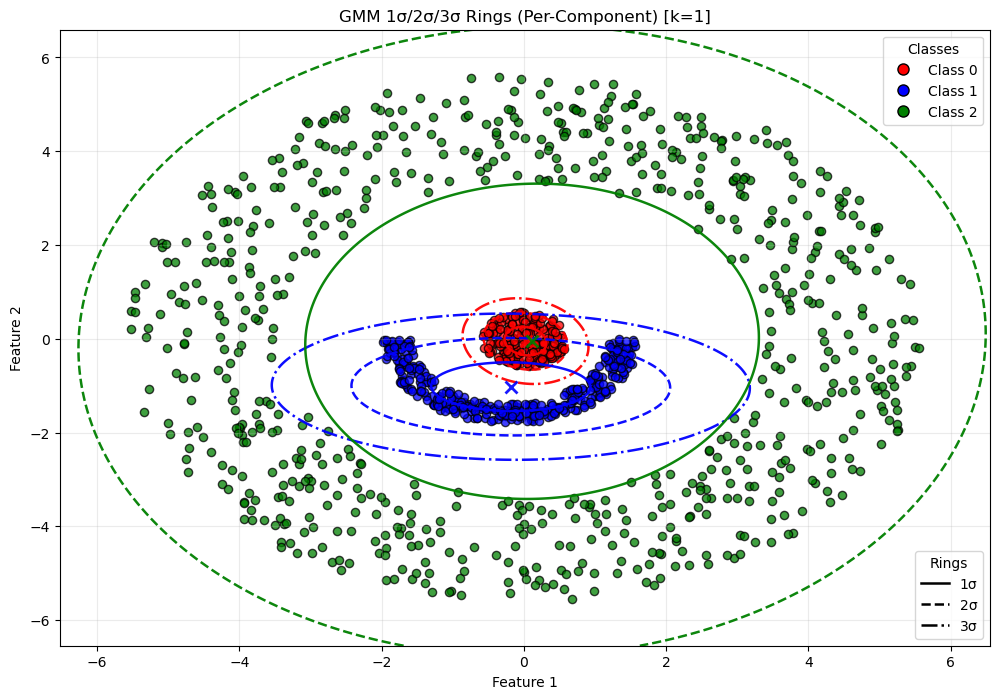

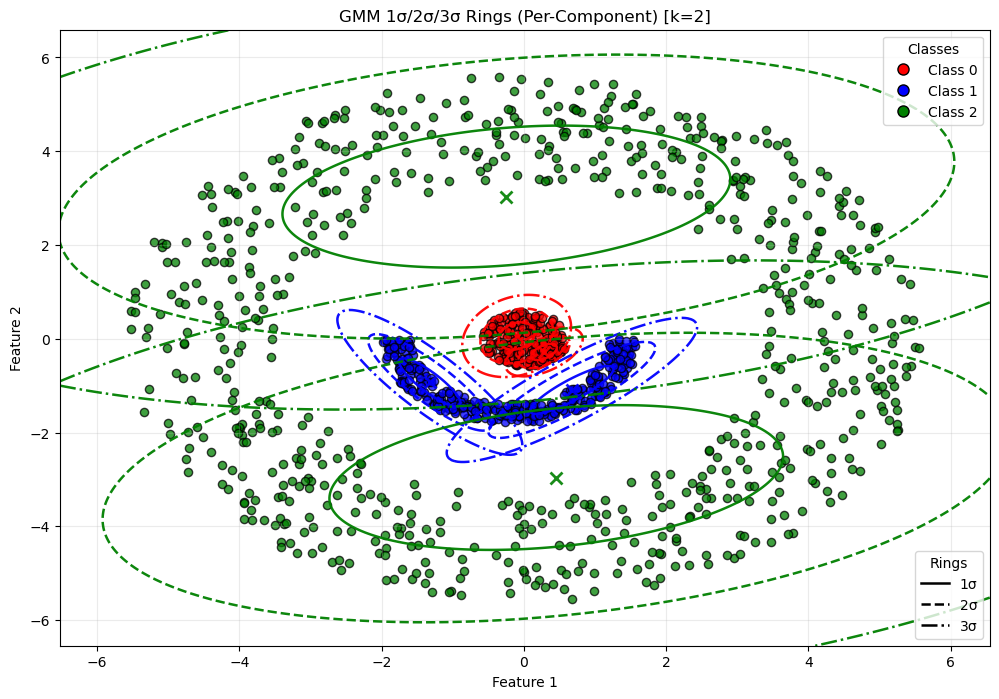

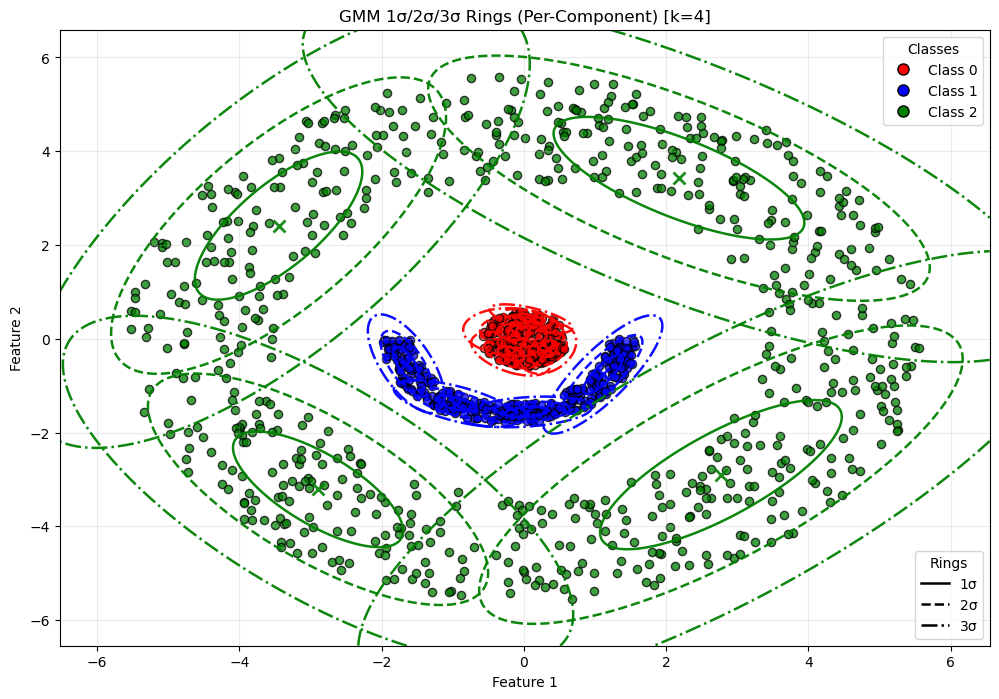

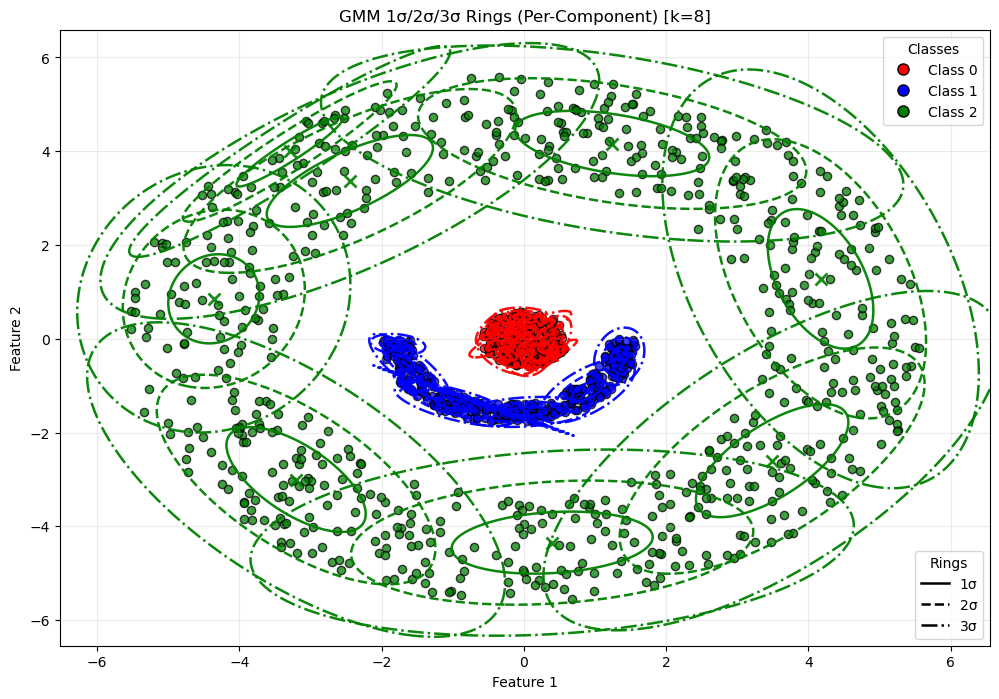

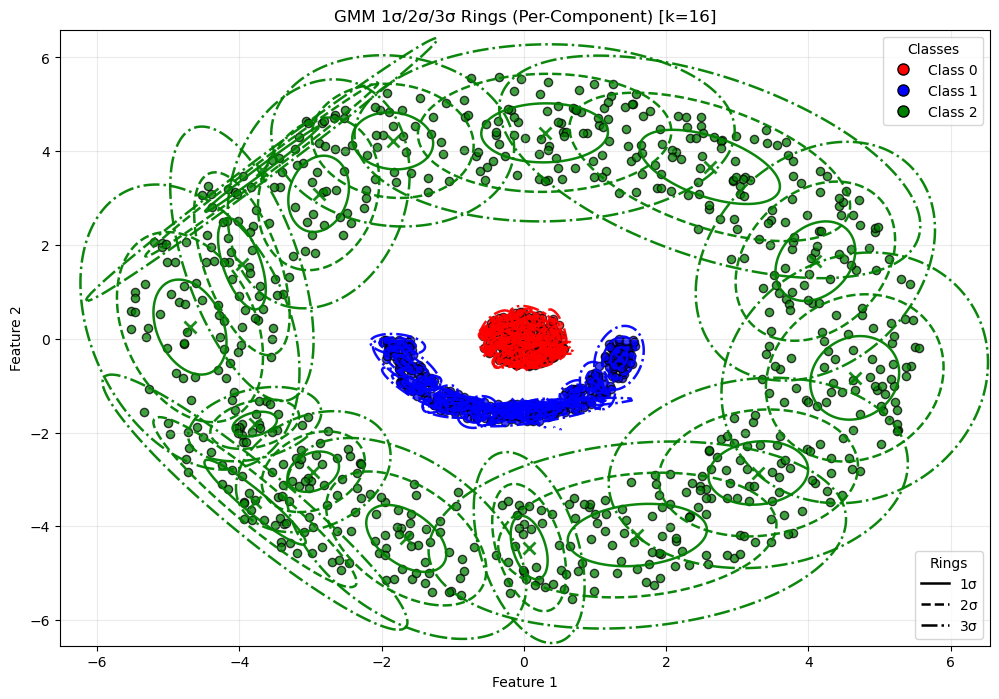

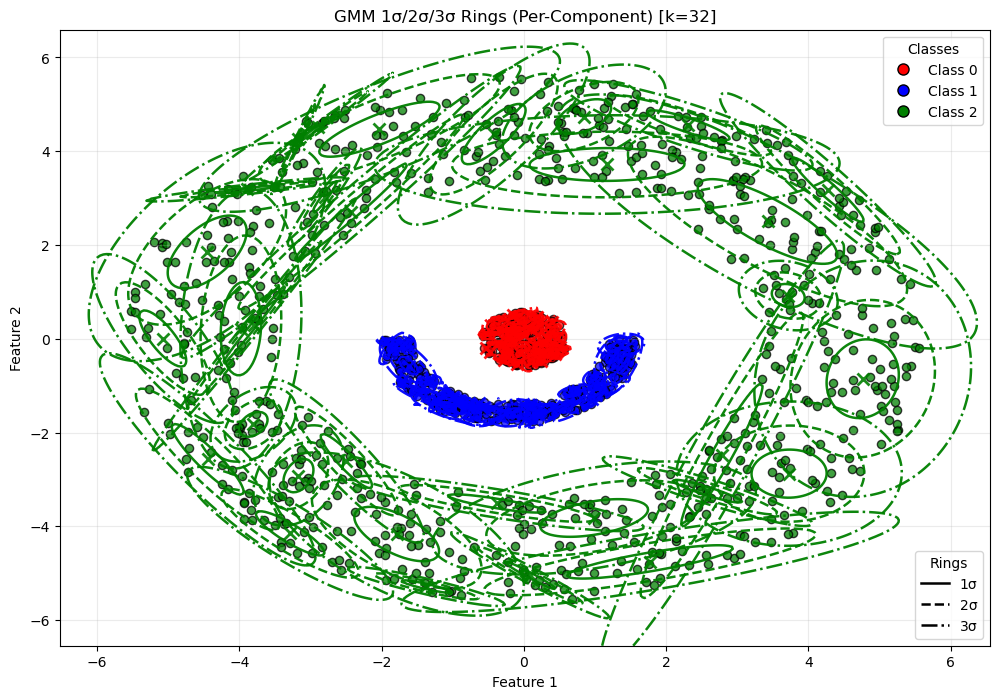

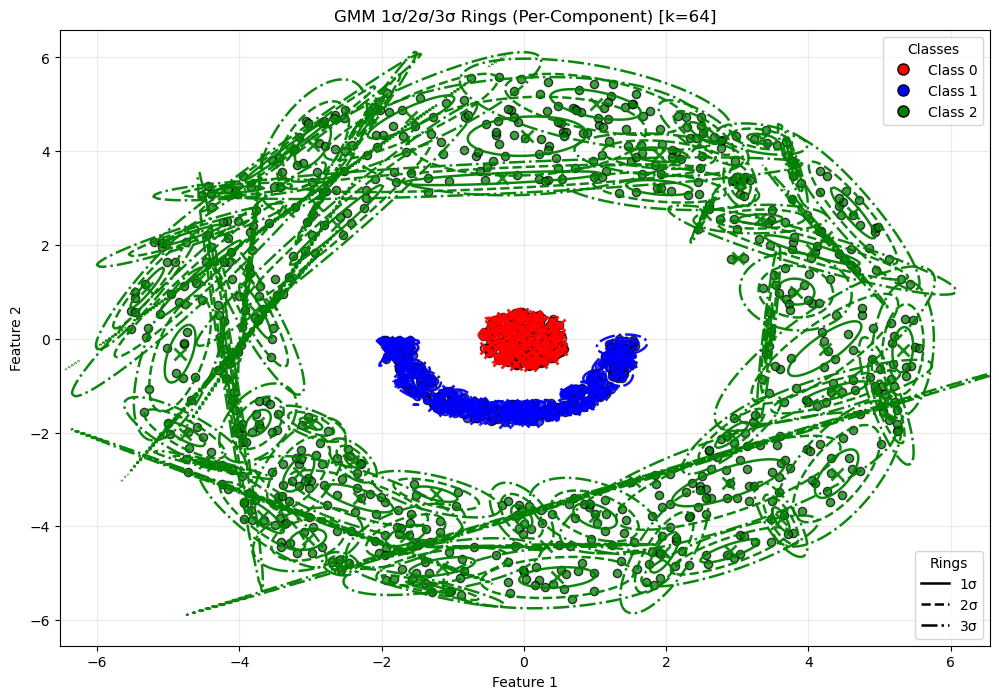

In [6]:
# Load the entire experiment
all_models, summary = load_experiment_results('saved_models/20251014_165139/')

# Choose which k to visualize: single int or list/tuple of ints
selected_k = [1,2, 4, 8, 16,32, 64]   # or selected_k = 8

# Helper: build minimal classifier for rings from saved model_data
class SavedClassifierForRings:
    def __init__(self, model_data):
        self.classes = model_data['classifier_params']['classes']
        self.gmm_models = {}
        for c in self.classes:
            params = model_data['gmm_params'][c]
            class G:  # tiny container
                pass
            g = G()
            g.means = params['means']
            g.covariances = params['covariances']
            g.weights = params['weights']
            g.n_components = len(params['weights'])
            self.gmm_models[c] = g

def plot_for_k(k_value):
    if k_value not in all_models:
        print(f"Requested k={k_value} not found in saved models. Available: {sorted(all_models.keys())}")
        return
    model_data = all_models[k_value]
    saved_classifier = SavedClassifierForRings(model_data)

    X_train_loaded = model_data['X_train']
    y_train_loaded = model_data['y_train']

    dynamic_title = f"GMM 1σ/2σ/3σ Rings (Per-Component) [k={k_value}]"
    fig = plot_gmm_sigma_circles(
        X_train_loaded,
        y_train_loaded,
        saved_classifier,
        title=dynamic_title
    )
    plt.show()

# Handle single k or multiple k values
if isinstance(selected_k, (list, tuple)):
    for k in selected_k:
        plot_for_k(k)
else:
    plot_for_k(selected_k)


Loading experiment results from: saved_models/20251014_170623/
Loading model from: saved_models\20251014_170623\k_1
Model loaded successfully!
- Components: 1
- Classes: 3
- Accuracy: 0.9891
Loading model from: saved_models\20251014_170623\k_2
Model loaded successfully!
- Components: 2
- Classes: 3
- Accuracy: 0.9901
Loading model from: saved_models\20251014_170623\k_4
Model loaded successfully!
- Components: 4
- Classes: 3
- Accuracy: 0.9910
Loading model from: saved_models\20251014_170623\k_8
Model loaded successfully!
- Components: 8
- Classes: 3
- Accuracy: 0.9910
Loading model from: saved_models\20251014_170623\k_16
Model loaded successfully!
- Components: 16
- Classes: 3
- Accuracy: 0.9915
Loading model from: saved_models\20251014_170623\k_32
Model loaded successfully!
- Components: 32
- Classes: 3
- Accuracy: 0.9915
Loading model from: saved_models\20251014_170623\k_64
Model loaded successfully!
- Components: 64
- Classes: 3
- Accuracy: 0.9915
Loaded 7 models from experiment


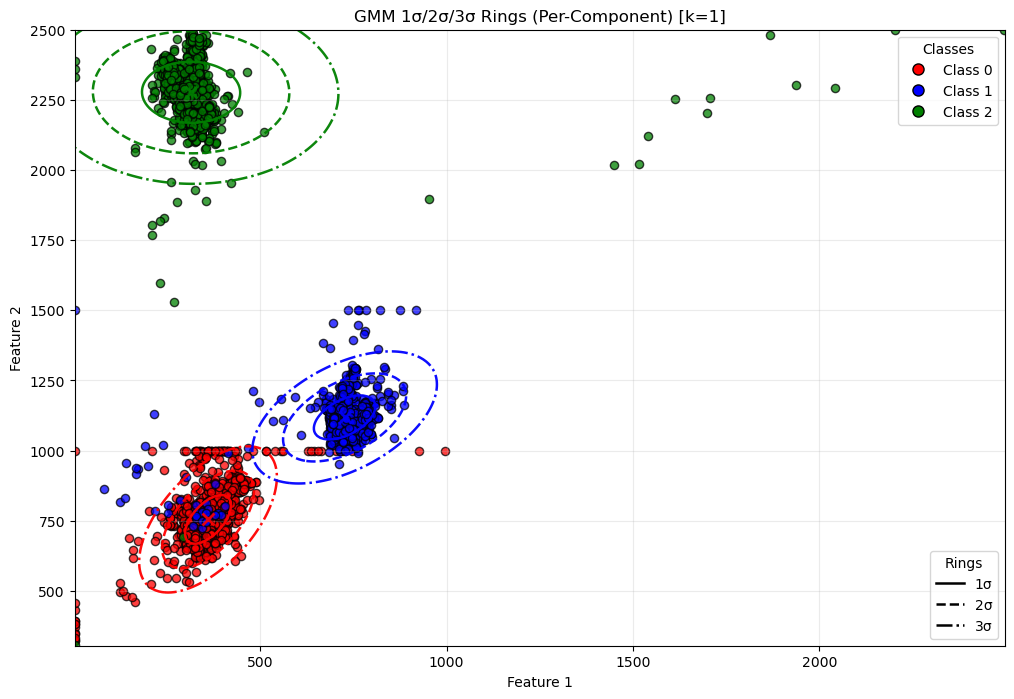

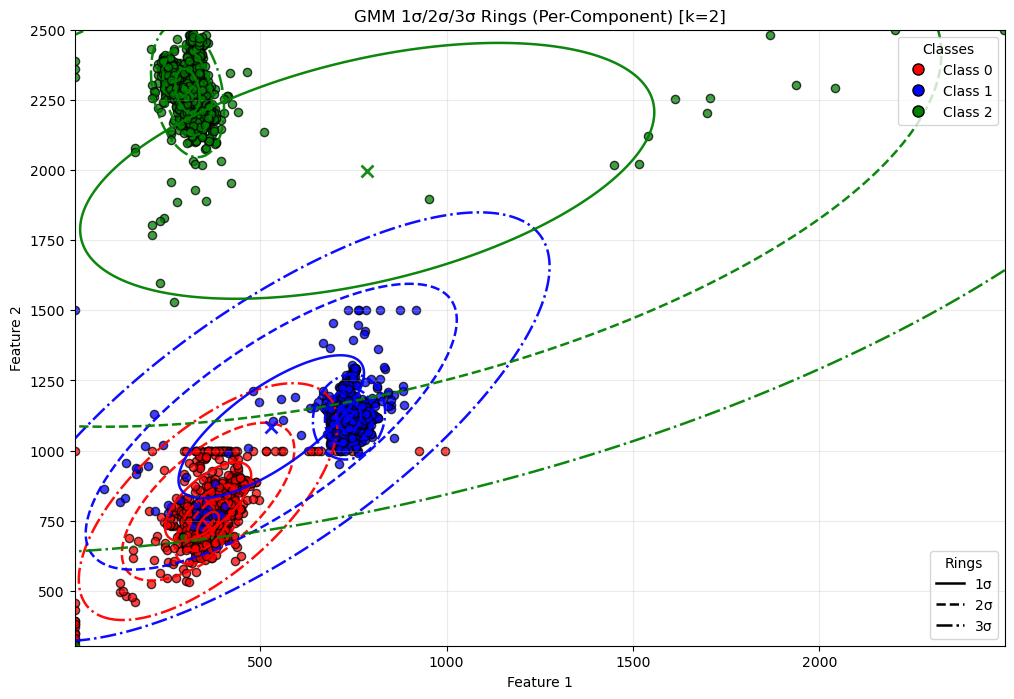

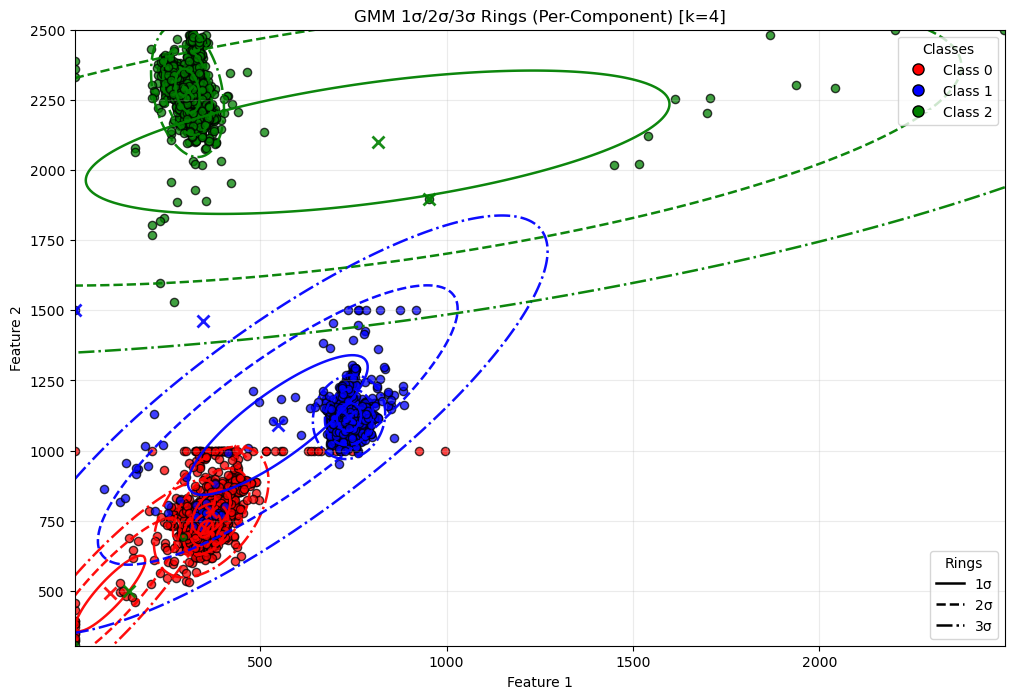

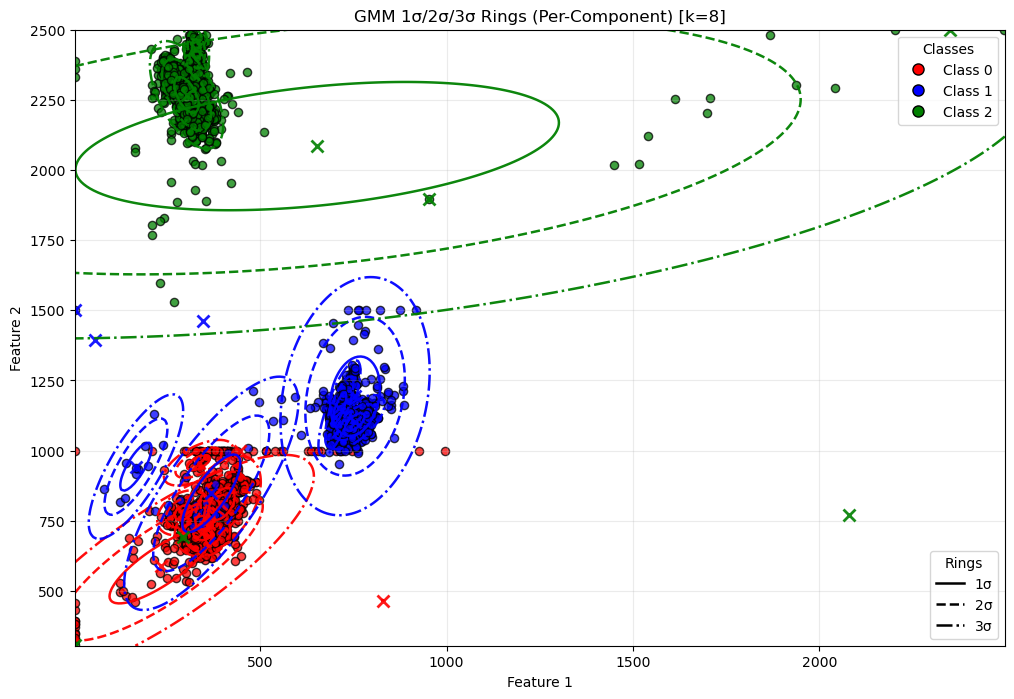

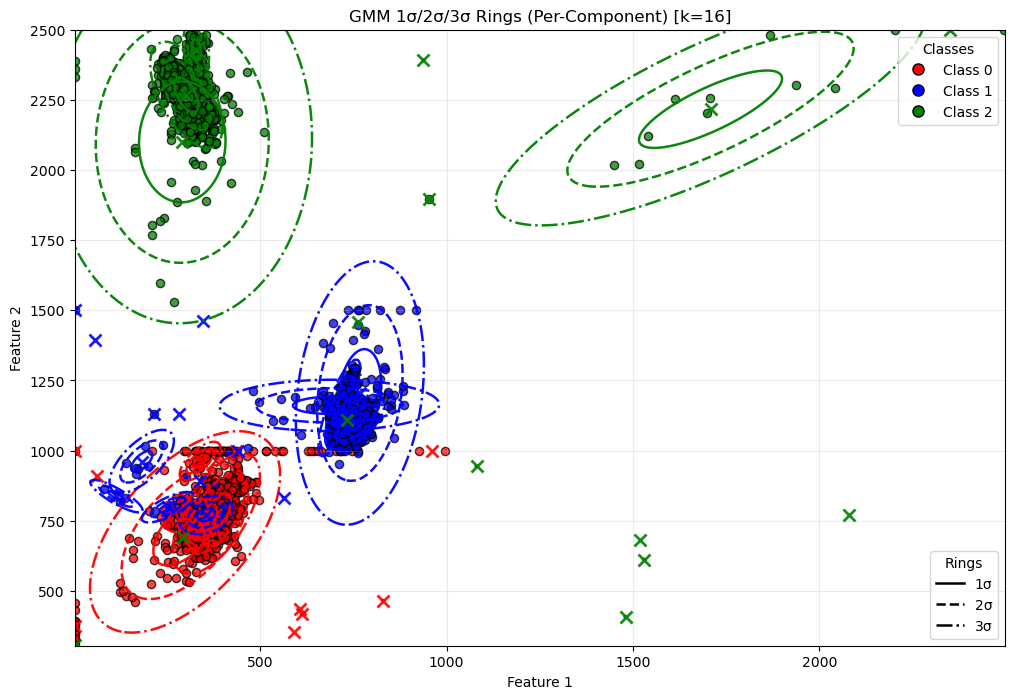

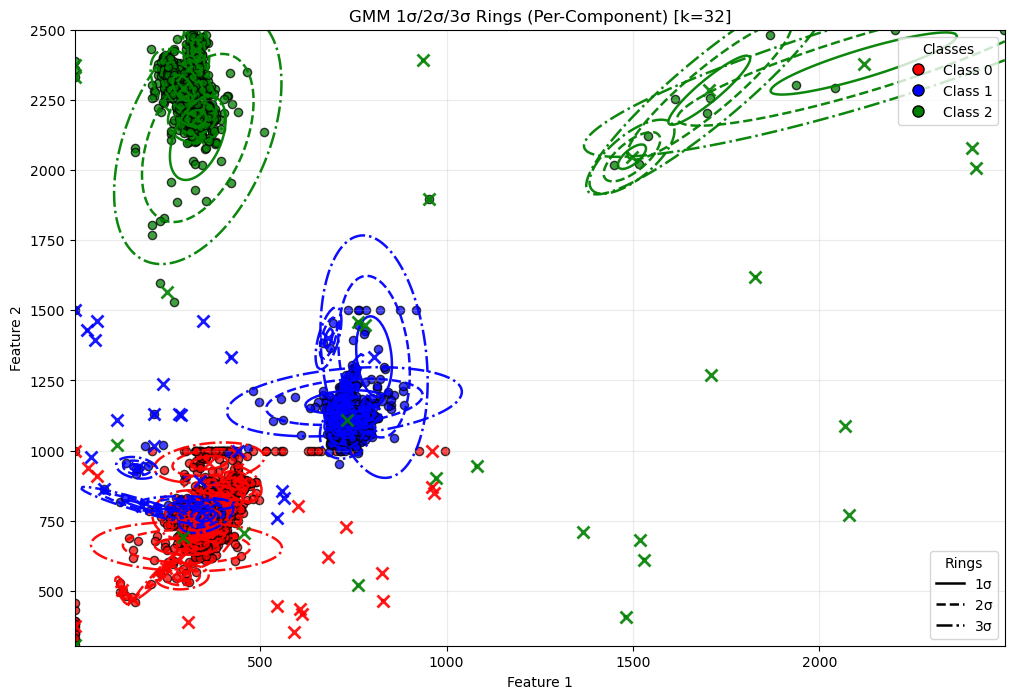

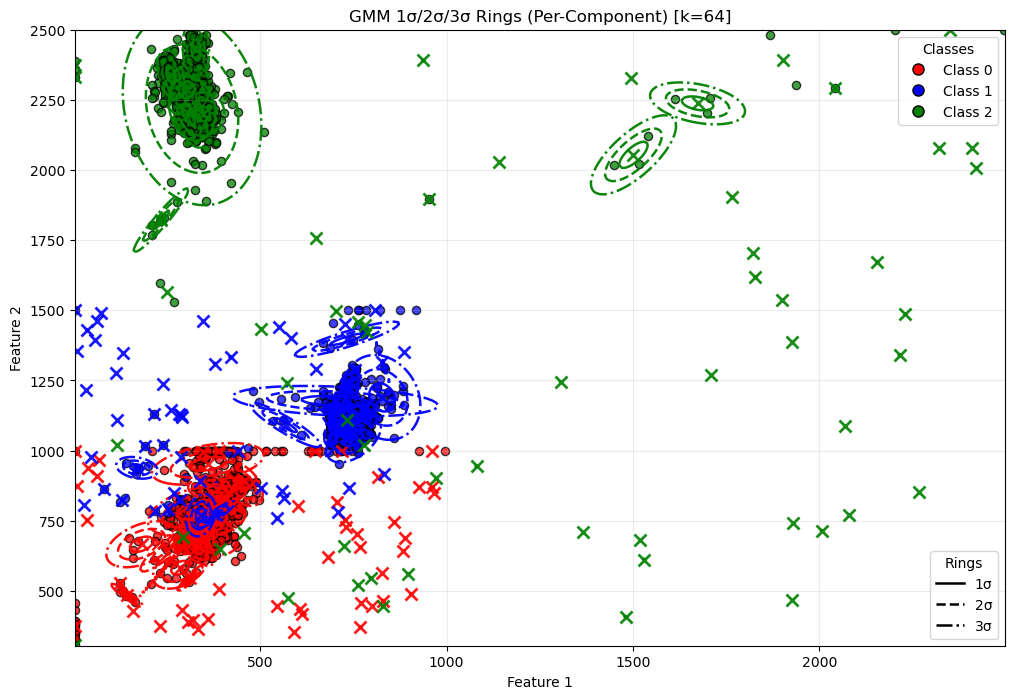

In [7]:
# Load the entire experiment
all_models, summary = load_experiment_results('saved_models/20251014_170623/')

# Choose which k to visualize: single int or list/tuple of ints
selected_k = [1,2, 4, 8, 16,32, 64]   # or selected_k = 8

# Helper: build minimal classifier for rings from saved model_data
class SavedClassifierForRings:
    def __init__(self, model_data):
        self.classes = model_data['classifier_params']['classes']
        self.gmm_models = {}
        for c in self.classes:
            params = model_data['gmm_params'][c]
            class G:  # tiny container
                pass
            g = G()
            g.means = params['means']
            g.covariances = params['covariances']
            g.weights = params['weights']
            g.n_components = len(params['weights'])
            self.gmm_models[c] = g

def plot_for_k(k_value):
    if k_value not in all_models:
        print(f"Requested k={k_value} not found in saved models. Available: {sorted(all_models.keys())}")
        return
    model_data = all_models[k_value]
    saved_classifier = SavedClassifierForRings(model_data)

    X_train_loaded = model_data['X_train']
    y_train_loaded = model_data['y_train']

    dynamic_title = f"GMM 1σ/2σ/3σ Rings (Per-Component) [k={k_value}]"
    fig = plot_gmm_sigma_circles(
        X_train_loaded,
        y_train_loaded,
        saved_classifier,
        title=dynamic_title
    )
    plt.show()

# Handle single k or multiple k values
if isinstance(selected_k, (list, tuple)):
    for k in selected_k:
        plot_for_k(k)
else:
    plot_for_k(selected_k)


In [13]:
# Load the entire experiment
all_models, summary = load_experiment_results('saved_models/20251014_173120/')

# Choose which k to visualize: single int or list/tuple of ints
selected_k = [2, 4, 8, 16,32,64]   # or selected_k = 8

# Helper: build minimal classifier for rings from saved model_data
class SavedClassifierForRings:
    def __init__(self, model_data):
        self.classes = model_data['classifier_params']['classes']
        self.gmm_models = {}
        for c in self.classes:
            params = model_data['gmm_params'][c]
            class G:  # tiny container
                pass
            g = G()
            g.means = params['means']
            g.covariances = params['covariances']
            g.weights = params['weights']
            g.n_components = len(params['weights'])
            self.gmm_models[c] = g

def plot_for_k(k_value):
    if k_value not in all_models:
        print(f"Requested k={k_value} not found in saved models. Available: {sorted(all_models.keys())}")
        return
    model_data = all_models[k_value]
    saved_classifier = SavedClassifierForRings(model_data)

    X_train_loaded = model_data['X_train']
    y_train_loaded = model_data['y_train']

    dynamic_title = f"GMM 1σ/2σ/3σ Rings (Per-Component) [k={k_value}]"
    fig = plot_gmm_sigma_circles(
        X_train_loaded,
        y_train_loaded,
        saved_classifier,
        title=dynamic_title
    )
    plt.show()

# Handle single k or multiple k values
if isinstance(selected_k, (list, tuple)):
    for k in selected_k:
        plot_for_k(k)
else:
    plot_for_k(selected_k)


Loading experiment results from: saved_models/20251014_173120/
Loading model from: saved_models\20251014_173120\k_2
Model loaded successfully!
- Components: 2
- Classes: 3
- Accuracy: 0.5267
Loading model from: saved_models\20251014_173120\k_4
Model loaded successfully!
- Components: 4
- Classes: 3
- Accuracy: 0.3200
Loading model from: saved_models\20251014_173120\k_8
Model loaded successfully!
- Components: 8
- Classes: 3
- Accuracy: 0.3333
Loading model from: saved_models\20251014_173120\k_16
Model loaded successfully!
- Components: 16
- Classes: 3
- Accuracy: 0.3333
Loading model from: saved_models\20251014_173120\k_32
Model loaded successfully!
- Components: 32
- Classes: 3
- Accuracy: 0.2933
Loading model from: saved_models\20251014_173120\k_64
Model loaded successfully!
- Components: 64
- Classes: 3
- Accuracy: 0.2533
Loaded 6 models from experiment
This visualization requires 2D features.
This visualization requires 2D features.
This visualization requires 2D features.
This vis

In [5]:
import os
import numpy as np
from glob import glob

def load_train_features(train_processed_dir):
    # Stack all train features for unsupervised fitting
    X_list = []
    files = sorted(glob(os.path.join(train_processed_dir, "*.npy")))
    for f in files:
        arr = np.load(f, allow_pickle=True)
        if arr.dtype == object:
            d = arr.item()
            F = d["features"]       # (num_patches, 2)
        else:
            F = arr                 # if you saved raw arrays
        if F.ndim == 1:
            F = F.reshape(1, -1)
        X_list.append(F)
    X_train = np.vstack(X_list) if X_list else np.empty((0,2))
    return X_train, files

def load_test_items(test_processed_dir):
    # Keep per-image features and shapes to generate per-image segmentations
    items = []
    files = sorted(glob(os.path.join(test_processed_dir, "*.npy")))
    for f in files:
        arr = np.load(f, allow_pickle=True)
        if arr.dtype == object:
            d = arr.item()
            F = d["features"]
            H, W = map(int, d.get("image_shape", (0,0)))
            patch_size = int(d.get("patch_size", 7))
            stride = int(d.get("stride", 1))
        else:
            F = arr
            H, W, patch_size, stride = 0, 0, 7, 1  # fallback
        if F.ndim == 1:
            F = F.reshape(1, -1)
        items.append({"path": f, "features": F, "image_shape": (H, W),
                      "patch_size": patch_size, "stride": stride})
    return items


In [12]:
# Paths to your processed npy folders
train_processed_dir = "../Dataset/Group04-cervical_cytology_images/group04/Train/processed/"
test_processed_dir  = "../Dataset/Group04-cervical_cytology_images/group04/Test/processed/"

# 1) Load
X_train, train_files = load_train_features(train_processed_dir)
test_items = load_test_items(test_processed_dir)
print("X_train:", X_train.shape, "| #train files:", len(train_files))
print("#test files:", len(test_items))

# 2) Fit K=3 K-means on training features
kmeans = KMeans(k=3, max_iters=100, random_state=42).fit(X_train)

# 3) Fit K=3 GMM initialized from K-means (uses EM)
gmm = GaussianMixtureModel(n_components=3, max_iters=100, tol=1e-6, random_state=42).fit(X_train)

# 4) Segment each test image per-file
def features_to_segmap(labels, image_shape, patch_size=7, stride=1):
    H, W = image_shape
    out_h = (H - patch_size) // stride + 1 if H and W else int(np.sqrt(len(labels)))
    out_w = (W - patch_size) // stride + 1 if H and W else int(np.sqrt(len(labels)))
    return labels.reshape(out_h, out_w)

seg_results = []
for item in test_items:
    F = item["features"]                # (num_patches, 2)
    H, W = item["image_shape"]
    ps, st = item["patch_size"], item["stride"]

    km_labels  = kmeans.predict(F)      # hard assignments
    gmm_labels = gmm.predict(F)         # likelihood-based hard assignments

    km_map  = features_to_segmap(km_labels,  (H, W), patch_size=ps, stride=st)
    gmm_map = features_to_segmap(gmm_labels, (H, W), patch_size=ps, stride=st)

    seg_results.append({"path": item["path"],
                        "km_segmap": km_map,
                        "gmm_segmap": gmm_map})


X_train: (15362160, 2) | #train files: 60
#test files: 3
K-means converged after 42 iterations
K-means converged after 42 iterations
iteration :  0
iteration :  1
iteration :  2
iteration :  3
iteration :  4


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def visualize_seg(original_gray, segmap, title="Segmentation"):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(original_gray, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(segmap, cmap='viridis');     plt.title(title);    plt.axis('off')
    plt.tight_layout(); plt.show()

# Example save (no original image required to save npy)
for res in seg_results:
    base = os.path.splitext(res["path"])[0]
    np.save(base + "_km_segmap.npy",  res["km_segmap"])
    np.save(base + "_gmm_segmap.npy", res["gmm_segmap"])
    # If you still have original images, you can visualize here using visualize_seg(...)


In [16]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

# -------- Configure this to your actual root --------
EXPERIMENT_ROOT = r"../Code/saved_models/"  # e.g., D:\...\Code\saved_models or your "models" dir
SAVE_PLOTS = True
OUTPUT_DIR = os.path.join(EXPERIMENT_ROOT, "plots_ll_curves")

# Your structure uses k_1, k_2, ..., k_64 under timestamped folders, with class_0/1/2 subdirs.
K_DIR_REGEX = re.compile(r"^k_(\d+)$")
CLASS_DIR_REGEX = re.compile(r"^class_\d+$")
LL_FILENAME = "log_likelihoods.npy"

def find_batches(root):
    # Batches are immediate subfolders like 20251014_165139
    batches = []
    if not os.path.isdir(root):
        return batches
    for name in os.listdir(root):
        path = os.path.join(root, name)
        if os.path.isdir(path):
            batches.append(path)
    return sorted(batches)

def discover_k_ll_paths(batch_dir):
    """
    Return dict {k: [paths to class_*/log_likelihoods.npy]} for a single batch.
    """
    k_to_lls = {}
    for name in os.listdir(batch_dir):
        k_match = K_DIR_REGEX.match(name)
        if not k_match:
            continue
        k_val = int(k_match.group(1))
        k_dir = os.path.join(batch_dir, name)
        if not os.path.isdir(k_dir):
            continue

        class_ll_paths = []
        for cname in os.listdir(k_dir):
            if not CLASS_DIR_REGEX.match(cname):
                continue
            cdir = os.path.join(k_dir, cname)
            ll_path = os.path.join(cdir, LL_FILENAME)
            if os.path.isfile(ll_path):
                class_ll_paths.append(ll_path)

        if class_ll_paths:
            k_to_lls[k_val] = class_ll_paths
    return k_to_lls

def load_and_align_curves(paths):
    """
    Load multiple 1D curves and align to shortest length to combine (e.g., mean across classes).
    Returns (iters, stacked_curves_2d) where stacked shape is (n_series, T).
    """
    curves = []
    for p in paths:
        arr = np.load(p)
        arr = np.squeeze(arr)
        if arr.ndim != 1:
            raise ValueError(f"{p} is not 1D after squeeze; got {arr.shape}")
        curves.append(arr)
    if not curves:
        return np.arange(0), np.empty((0, 0))
    min_len = min(len(c) for c in curves)
    curves_trim = [c[:min_len] for c in curves]
    stacked = np.vstack(curves_trim)
    iters = np.arange(1, min_len + 1)
    return iters, stacked

def plot_batch(batch_dir, k_to_lls, outdir=None, show=False):
    """
    For one batch, average class curves per k and plot Iteration vs Log-Likelihood.
    """
    if not k_to_lls:
        return

    plt.figure(figsize=(8, 5))
    for k in sorted(k_to_lls.keys()):
        iters, stacked = load_and_align_curves(k_to_lls[k])
        if stacked.size == 0:
            continue
        mean_curve = stacked.mean(axis=0)
        plt.plot(iters, mean_curve, label=f"k={k}")

    batch_name = os.path.basename(batch_dir.rstrip("/\\"))
    plt.title(f"{batch_name} — Iterations vs Log-Likelihood")
    plt.xlabel("Iteration")
    plt.ylabel("Log-Likelihood")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Components (k)", loc="best")

    if outdir:
        os.makedirs(outdir, exist_ok=True)
        png_path = os.path.join(outdir, f"{batch_name}_ll_curves.png")
        plt.tight_layout()
        plt.savefig(png_path, dpi=160)
        print(f"Saved: {png_path}")
        plt.close()
    else:
        plt.tight_layout()
        if show or not SAVE_PLOTS:
            plt.show()

def main():
    batches = find_batches(EXPERIMENT_ROOT)
    if not batches:
        raise SystemExit(f"No subfolders found under {EXPERIMENT_ROOT}. Set EXPERIMENT_ROOT correctly.")

    any_plotted = False
    for b in batches:
        k_to_lls = discover_k_ll_paths(b)
        if k_to_lls:
            any_plotted = True
            plot_batch(b, k_to_lls, outdir=OUTPUT_DIR if SAVE_PLOTS else None, show=not SAVE_PLOTS)
        else:
            print(f"Warning: no k_*/class_*/{LL_FILENAME} found in {b}")

    if not any_plotted:
        raise SystemExit(f"No datasets with k_*/class_*/{LL_FILENAME} found under {EXPERIMENT_ROOT}")

if __name__ == "__main__":
    main()


Saved: ../Code/saved_models/plots_ll_curves\20251014_165139_ll_curves.png
Saved: ../Code/saved_models/plots_ll_curves\20251014_170623_ll_curves.png
Saved: ../Code/saved_models/plots_ll_curves\20251014_172839_ll_curves.png


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

# -------------------- UPDATE THESE TO YOUR BEST RUNS --------------------
# Example choices (replace with your actual best k folders):
DS1_DIR = r"../Code/saved_models/20251014_170623/k_4"     # Dataset-1 best model folder
DS2A_DIR = r"../Code/saved_models/20251014_172839/k_8"    # Dataset-2(a) best model folder
CLASS_DIRS = ["class_0", "class_1", "class_2"]            # adjust if your class names differ
# -----------------------------------------------------------------------

def load_gmm_class_params(class_dir):
    means = np.load(os.path.join(class_dir, "means.npy"))        # (Kc, D)
    covs = np.load(os.path.join(class_dir, "covariances.npy"))   # (Kc, D, D)
    weights = np.load(os.path.join(class_dir, "weights.npy"))    # (Kc,)
    return means, covs, weights

def load_run(run_dir, class_dirs):
    X_train = np.load(os.path.join(run_dir, "X_train.npy"))
    y_train = np.load(os.path.join(run_dir, "y_train.npy"))
    class_models = []
    for cname in class_dirs:
        cdir = os.path.join(run_dir, cname)
        means, covs, weights = load_gmm_class_params(cdir)
        class_models.append((means, covs, weights))
    return X_train, y_train, class_models

def class_log_like_2d(x2, class_model_2d):
    means, covs, weights = class_model_2d
    logs = []
    for mu, S, w in zip(means, covs, weights):
        mvn = multivariate_normal(mean=mu, cov=S, allow_singular=True)
        logs.append(np.log(w + 1e-12) + mvn.logpdf(x2))
    logs = np.asarray(logs)
    m = logs.max()
    return m + np.log(np.exp(logs - m).sum())

def predict_grid(grid2, class_models_2d, priors=None):
    C = len(class_models_2d)
    if priors is None:
        priors = np.ones(C) / C
    priors = np.asarray(priors)
    Z = np.empty(grid2.shape[0], dtype=np.int32)
    for i, x in enumerate(grid2):
        scores = [np.log(priors[c] + 1e-12) + class_log_like_2d(x, class_models_2d[c]) for c in range(C)]
        Z[i] = int(np.argmax(scores))
    return Z

def plot_decision_regions_for_run(run_dir, class_dirs, title, h=0.02, save_name="decision_regions.png"):
    X_train, y_train, class_models = load_run(run_dir, class_dirs)
    if X_train.shape[1] < 2:
        raise ValueError("Need at least 2 features to plot 2D decision regions.")

    # Use first two features for visualization
    X2 = X_train[:, :2]
    class_models_2d = []
    for means, covs, weights in class_models:
        class_models_2d.append((means[:, :2], covs[:, :2, :2], weights))

    x_min, x_max = X2[:,0].min() - 0.5, X2[:,0].max() + 0.5
    y_min, y_max = X2[:,1].min() - 0.5, X2[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict_grid(grid, class_models_2d).reshape(xx.shape)

    cmap_bg = ListedColormap(["#FFEEEE", "#EEFFEE", "#EEEEFF"])
    cmap_pts = ListedColormap(["#FF0000", "#00AA00", "#0000FF"])

    plt.figure(figsize=(6.5, 5.5))
    plt.contourf(xx, yy, Z, alpha=0.35, cmap=cmap_bg)
    sc = plt.scatter(X2[:,0], X2[:,1], c=y_train, cmap=cmap_pts, s=24, edgecolor="k", linewidths=0.3, alpha=0.95)

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    # Build a simple legend for classes 0..C-1
    C = len(class_dirs)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w',
                                   markerfacecolor=cmap_pts.colors[i], markeredgecolor='k',
                                   markersize=7, label=f"class {i}") for i in range(C)],
               title="Train classes", loc="best")
    out_path = os.path.join(run_dir, save_name)
    plt.tight_layout()
    plt.savefig(out_path, dpi=160)
    print(f"Saved: {out_path}")
    plt.close()

if __name__ == "__main__":
    # Dataset-1
    plot_decision_regions_for_run(
        DS1_DIR, CLASS_DIRS,
        title="Dataset-1 — Decision regions (best model)",
        save_name="decision_regions_ds1.png"
    )
    # Dataset-2(a)
    plot_decision_regions_for_run(
        DS2A_DIR, CLASS_DIRS,
        title="Dataset-2(a) — Decision regions (best model)",
        save_name="decision_regions_ds2a.png"
    )


MemoryError: Unable to allocate 102. GiB for an array with shape (109816, 124660) and data type float64

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal
import os

# Tunables
H = 0.5                 # grid step (coarser grid -> far less memory)
P_LOW, P_HIGH = 1, 99   # clip bounds to percentiles
BATCH = 200_000         # max grid points per batch to predict

def class_log_like_2d(x2, class_model_2d):
    means, covs, weights = class_model_2d
    logs = []
    for mu, S, w in zip(means, covs, weights):
        mvn = multivariate_normal(mean=mu, cov=S, allow_singular=True)
        logs.append(np.log(w + 1e-12) + mvn.logpdf(x2))
    logs = np.asarray(logs)
    m = logs.max()
    return m + np.log(np.exp(logs - m).sum())

def predict_grid_batched(grid2, class_models_2d, priors=None, batch=BATCH):
    C = len(class_models_2d)
    if priors is None:
        priors = np.ones(C) / C
    priors = np.asarray(priors)
    Z = np.empty(grid2.shape[0], dtype=np.int32)
    for start in range(0, grid2.shape[0], batch):
        end = min(start + batch, grid2.shape[0])
        G = grid2[start:end]
        # evaluate per point
        for i, x in enumerate(G):
            scores = [np.log(priors[c] + 1e-12) + class_log_like_2d(x, class_models_2d[c]) for c in range(C)]
            Z[start + i] = int(np.argmax(scores))
    return Z

def plot_decision_regions_for_run_safe(run_dir, class_dirs, title, h=H, save_name="decision_regions.png"):
    X_train = np.load(os.path.join(run_dir, "X_train.npy"))
    y_train = np.load(os.path.join(run_dir, "y_train.npy"))
    class_models = []
    for cname in class_dirs:
        cdir = os.path.join(run_dir, cname)
        means = np.load(os.path.join(cdir, "means.npy"))
        covs = np.load(os.path.join(cdir, "covariances.npy"))
        weights = np.load(os.path.join(cdir, "weights.npy"))
        class_models.append((means, covs, weights))

    if X_train.shape[1] < 2:
        raise ValueError("Need at least 2 features to plot 2D decision regions.")

    X2 = X_train[:, :2]

    # Clip bounds to robust range
    x1_low, x1_high = np.percentile(X2[:,0], [P_LOW, P_HIGH])
    x2_low, x2_high = np.percentile(X2[:,1], [P_LOW, P_HIGH])
    pad1 = 0.1 * (x1_high - x1_low + 1e-9)
    pad2 = 0.1 * (x2_high - x2_low + 1e-9)
    x_min, x_max = x1_low - pad1, x1_high + pad1
    y_min, y_max = x2_low - pad2, x2_high + pad2

    xs = np.arange(x_min, x_max, h, dtype=np.float32)
    ys = np.arange(y_min, y_max, h, dtype=np.float32)
    xx, yy = np.meshgrid(xs, ys, indexing="xy")
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Reduce GMMs to 2D
    class_models_2d = []
    for means, covs, weights in class_models:
        class_models_2d.append((means[:, :2], covs[:, :2, :2], weights))

    Z = predict_grid_batched(grid, class_models_2d).reshape(xx.shape)

    cmap_bg = ListedColormap(["#FFEEEE", "#EEFFEE", "#EEEEFF"])
    cmap_pts = ListedColormap(["#FF0000", "#00AA00", "#0000FF"])

    plt.figure(figsize=(6.5, 5.5))
    plt.contourf(xx, yy, Z, alpha=0.35, cmap=cmap_bg)
    sc = plt.scatter(X2[:,0], X2[:,1], c=y_train, cmap=cmap_pts, s=24, edgecolor="k", linewidths=0.3, alpha=0.95)

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    C = len(class_dirs)
    plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w',
                                   markerfacecolor=cmap_pts.colors[i], markeredgecolor='k',
                                   markersize=7, label=f"class {i}") for i in range(C)],
               title="Train classes", loc="best")

    out_path = os.path.join(run_dir, save_name)
    plt.tight_layout()
    plt.savefig(out_path, dpi=160)
    print(f"Saved: {out_path}")
    plt.close()


In [19]:
# Dataset-1
plot_decision_regions_for_run_safe(
    DS1_DIR, CLASS_DIRS,
    title="Dataset-1 — Decision regions (best model)",
    save_name="decision_regions_ds1.png"
)

# Dataset-2(a)
plot_decision_regions_for_run_safe(
    DS2A_DIR, CLASS_DIRS,
    title="Dataset-2(a) — Decision regions (best model)",
    save_name="decision_regions_ds2a.png"
)


KeyboardInterrupt: 

In [20]:
import os
import re
import numpy as np

# Root of your saved models
SAVED_MODELS_ROOT = r"../Code/saved_models"  # change if needed

# Output .tex file collecting all tables
OUTPUT_TEX = os.path.join(SAVED_MODELS_ROOT, "all_metrics_tables.tex")

# Optional: pretty dataset names mapping (folder -> display name)
DATASET_NAME_MAP = {
    # "20251014_170623": "Dataset-1",
    # "20251014_172839": "Dataset-2(a)",
    # Add mappings if you want custom titles; otherwise folder name is used
}

# Recognize k folders
K_DIR_RE = re.compile(r"^k_(\d+)$")

def list_batches(root):
    batches = []
    for name in os.listdir(root):
        p = os.path.join(root, name)
        if os.path.isdir(p):
            batches.append(p)
    return sorted(batches)

def list_k_dirs(batch_dir):
    out = []
    for name in os.listdir(batch_dir):
        m = K_DIR_RE.match(name)
        if not m:
            continue
        out.append((int(m.group(1)), os.path.join(batch_dir, name)))
    out.sort(key=lambda t: t[0])
    return out

def safe_load(path):
    if not os.path.isfile(path):
        return None
    return np.load(path, allow_pickle=False)

def per_class_accuracy_from_confusion(cm):
    # cm shape (C, C), rows: true, cols: pred
    cm = np.asarray(cm)
    diag = np.diag(cm).astype(float)
    row_sums = cm.sum(axis=1).astype(float)
    with np.errstate(divide="ignore", invalid="ignore"):
        acc = np.divide(diag, row_sums, out=np.zeros_like(diag, dtype=float), where=row_sums>0)
    return acc  # fraction 0..1

def format_float_pct(x):
    # expects 0..1 -> prints percentage with 2 decimals
    return f"{x*100:.2f}"

def ensure_one_dim(arr, name):
    arr = np.squeeze(arr)
    if arr.ndim != 1:
        raise ValueError(f"{name} must be 1D after squeeze; got {arr.shape}")
    return arr

def build_latex_table(dataset_name, k, class_acc, prec, rec, f1):
    # All arrays are per-class fractions 0..1
    C = len(f1)
    # Compute macro means
    macro_acc = float(np.mean(class_acc)) if class_acc is not None else None
    macro_prec = float(np.mean(prec)) if prec is not None else None
    macro_rec = float(np.mean(rec)) if rec is not None else None
    macro_f1 = float(np.mean(f1)) if f1 is not None else None

    # Header line
    caption = (
        f"\\caption{{Classification metrics for {dataset_name} --- Model: GMM initialized by KMeans "
        f"(example: \\(K={k}\\) mixtures).}}"
    )
    label = f"\\label{{tab:metrics_{dataset_name.replace(' ', '_')}_k{k}}}"

    header = (
        caption + "\n" + label + "\n"
        + "\\begin{tabular}{l S[table-format=3.2] S[table-format=3.2] S[table-format=3.2] S[table-format=3.2]}\n"
        "\\toprule\n"
        "Class & {Accuracy (\\%)} & {Precision (\\%)} & {Recall (\\%)} & {F1 (\\%)} \\\\\n"
        "\\midrule\n"
    )

    # Rows
    rows = []
    for i in range(C):
        acc_str = format_float_pct(class_acc[i]) if class_acc is not None else ""
        p_str = format_float_pct(prec[i]) if prec is not None else ""
        r_str = format_float_pct(rec[i]) if rec is not None else ""
        f1_str = format_float_pct(f1[i]) if f1 is not None else ""
        rows.append(f"Class {i+1} & {acc_str} & {p_str} & {r_str} & {f1_str} \\\\")

    # Macro line
    macro_acc_str = format_float_pct(macro_acc) if macro_acc is not None else ""
    macro_prec_str = format_float_pct(macro_prec) if macro_prec is not None else ""
    macro_rec_str = format_float_pct(macro_rec) if macro_rec is not None else ""
    macro_f1_str = format_float_pct(macro_f1) if macro_f1 is not None else ""

    macro = (
        "\\midrule\n"
        f"Mean (macro) & {macro_acc_str} & {macro_prec_str} & {macro_rec_str} & {macro_f1_str} \\\\\n"
        "\\bottomrule\n"
        "\\end{tabular}\n"
        "\\end{table}\n"
        "\\noindent\\metricsTableCaption\n"
    )

    table = header + "\n".join(rows) + "\n" + macro + "\n"
    return table

def main():
    tables = []
    batches = list_batches(SAVED_MODELS_ROOT)
    for batch_dir in batches:
        dataset_key = os.path.basename(batch_dir.rstrip("/\\"))
        dataset_name = DATASET_NAME_MAP.get(dataset_key, dataset_key)
        k_dirs = list_k_dirs(batch_dir)
        if not k_dirs:
            continue

        for k, k_dir in k_dirs:
            # Load metrics
            prec = safe_load(os.path.join(k_dir, "precision.npy"))
            rec = safe_load(os.path.join(k_dir, "recall.npy"))
            f1 = safe_load(os.path.join(k_dir, "f1_score.npy"))
            cm = safe_load(os.path.join(k_dir, "confusion_matrix.npy"))

            if f1 is None and (prec is None or rec is None):
                print(f"Skipping {dataset_name} k={k}: metrics files missing in {k_dir}")
                continue

            # Ensure 1D arrays
            if prec is not None: prec = ensure_one_dim(prec, "precision.npy")
            if rec is not None: rec = ensure_one_dim(rec, "recall.npy")
            if f1 is not None: f1 = ensure_one_dim(f1, "f1_score.npy")

            # Accuracy per class from confusion matrix if available
            class_acc = None
            if cm is not None:
                class_acc = per_class_accuracy_from_confusion(cm)
            elif prec is not None and rec is not None and f1 is not None:
                # If no confusion matrix, leave accuracy blank; table still prints other metrics.
                pass

            # Infer number of classes C
            if f1 is not None:
                C = f1.shape[0]
            elif prec is not None:
                C = prec.shape[0]
            elif rec is not None:
                C = rec.shape[0]
            elif class_acc is not None:
                C = class_acc.shape[0]
            else:
                print(f"Skipping {dataset_name} k={k}: cannot infer number of classes.")
                continue

            # Align lengths if some arrays missing or mismatched
            def trim(arr):
                return arr[:C] if arr is not None and arr.shape[0] >= C else arr
            prec, rec, f1, class_acc = map(trim, (prec, rec, f1, class_acc))

            # Build table
            table_tex = build_latex_table(dataset_name, k, class_acc, prec, rec, f1)
            tables.append(table_tex)

    if not tables:
        raise SystemExit(f"No tables generated. Check paths and metric files under {SAVED_MODELS_ROOT}")

    # Write single TeX file with all tables
    with open(OUTPUT_TEX, "w", encoding="utf-8") as f:
        f.write("% Auto-generated metrics tables\n\n")
        for t in tables:
            f.write(t)
            f.write("\n")

    print(f"Wrote LaTeX tables to: {OUTPUT_TEX}")

if __name__ == "__main__":
    main()


Wrote LaTeX tables to: ../Code/saved_models\all_metrics_tables.tex


In [21]:
import os
import re
import numpy as np

# Root directory containing your datasets/batches (e.g., 20251014_165139, ...)
SAVED_MODELS_ROOT = r"../Code/saved_models"   # adjust to your path
OUTPUT_TEX = os.path.join(SAVED_MODELS_ROOT, "all_confusion_matrices.tex")

# Display names (optional)
DATASET_NAME_MAP = {
    # "20251014_170623": "Dataset-1",
    # "20251014_172839": "Dataset-2(a)",
}

# Toggle: show counts or row-normalized percentages in table
SHOW_PERCENT = False   # set True to print percentages
DECIMALS = 2           # decimals for percentages

K_DIR_RE = re.compile(r"^k_(\d+)$")

def list_batches(root):
    return sorted([os.path.join(root, d) for d in os.listdir(root)
                   if os.path.isdir(os.path.join(root, d))])

def list_k_dirs(batch_dir):
    ks = []
    for name in os.listdir(batch_dir):
        m = K_DIR_RE.match(name)
        if m:
            ks.append((int(m.group(1)), os.path.join(batch_dir, name)))
    ks.sort(key=lambda t: t[0])
    return ks

def load_confusion(k_dir):
    path = os.path.join(k_dir, "confusion_matrix.npy")
    if not os.path.isfile(path):
        return None
    cm = np.load(path, allow_pickle=False)
    cm = np.asarray(cm)
    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError(f"Invalid confusion matrix shape in {path}: {cm.shape}")
    return cm

def to_percent_rows(cm):
    cm = cm.astype(float)
    row_sums = cm.sum(axis=1, keepdims=True)
    with np.errstate(divide="ignore", invalid="ignore"):
        pct = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums > 0)
    return pct

def latex_confusion_table(dataset_name, k, cm, show_percent=False, decimals=2):
    C = cm.shape[0]
    caption = (
        f"\\caption{{Confusion matrix for {dataset_name} --- GMM (\\(K={k}\\))."
        + (" Row-normalized (\\%)." if show_percent else " Counts.") + "}}"
    )
    label = f"\\label{{tab:cm_{dataset_name.replace(' ', '_')}_k{k}}}"

    # Column alignment: 1 label column + C numeric columns
    col_spec = "l " + " ".join(["S[table-format=4.0]" if not show_percent else f"S[table-format=3.{decimals}]" for _ in range(C)])
    header = caption + "\n" + label + "\n" + f"\\begin{{tabular}}{{{col_spec}}}\n\\toprule\n"

    # Column headers
    col_headers = " & " + " & ".join([f"Pred {j+1}" for j in range(C)]) + " \\\\\n\\midrule\n"
    body_lines = []

    if show_percent:
        data = to_percent_rows(cm) * 100.0
        fmt = f"{{:.{decimals}f}}"
        for i in range(C):
            row_vals = " & ".join(fmt.format(v) for v in data[i])
            body_lines.append(f"True {i+1} & {row_vals} \\\\")
    else:
        data = cm.astype(int)
        for i in range(C):
            row_vals = " & ".join(str(int(v)) for v in data[i])
            body_lines.append(f"True {i+1} & {row_vals} \\\\")

    footer = "\n\\bottomrule\n\\end{tabular}\n\\end{table}\n\\noindent\\confusionMatrixCaption\n\n"
    return header + col_headers + "\n".join(body_lines) + footer

def main():
    tables = []
    batches = list_batches(SAVED_MODELS_ROOT)
    for b in batches:
        dataset_key = os.path.basename(b.rstrip("/\\"))
        dataset_name = DATASET_NAME_MAP.get(dataset_key, dataset_key)
        for k, k_dir in list_k_dirs(b):
            cm = load_confusion(k_dir)
            if cm is None:
                print(f"Skipping {dataset_name} k={k}: confusion_matrix.npy not found in {k_dir}")
                continue
            table_tex = latex_confusion_table(dataset_name, k, cm, show_percent=SHOW_PERCENT, decimals=DECIMALS)
            tables.append(table_tex)

    if not tables:
        raise SystemExit(f"No confusion matrices found under {SAVED_MODELS_ROOT}")

    with open(OUTPUT_TEX, "w", encoding="utf-8") as f:
        f.write("% Auto-generated confusion matrix tables\n\n")
        for t in tables:
            f.write(t)

    print(f"Wrote LaTeX confusion matrices to: {OUTPUT_TEX}")

if __name__ == "__main__":
    main()


Wrote LaTeX confusion matrices to: ../Code/saved_models\all_confusion_matrices.tex
